# Zindi landslide prediction challenge solution

## 1. Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math as mt
import matplotlib.image as mpimg
import warnings

%matplotlib inline
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier#, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

# !pip install mlxtend
from mlxtend.classifier import StackingClassifier

## 2. Load data

In [4]:
train = pd.read_csv('Zindi_Train.csv')
test = pd.read_csv('Zindi_Test.csv')
train.head()

Sample_ID  1_elevation  2_elevation  3_elevation  4_elevation  5_elevation  \
0          1          130          129          127          126          123   
1          2          161          158          155          153          151   
2          3          149          151          154          156          158   
3          4           80           78           77           75           73   
4          5          117          115          114          112          110   

   6_elevation  7_elevation  8_elevation  9_elevation  ...  17_sdoif  \
0          126          125          124          122  ...  1.281779   
1          162          159          155          153  ...  1.359639   
2          154          157          158          160  ...  1.365005   
3           80           78           77           75  ...  1.100708   
4          115          113          111          110  ...  1.284180   

   18_sdoif  19_sdoif  20_sdoif  21_sdoif  22_sdoif  23_sdoif  24_sdoif  \
0  1.281743  1.281720  1.281684  1.281811  1.281788  1.281752  1.281729   
1  1.359608  1.359587  1.359556  1.359683  1.359662  1.359631  1.359610   
2  1.365025  1.365055  1.365075  1.364937  1.364967  1.364988  1.365018   
3  1.100738  1.100759  1.100789  1.100630  1.100650  1.100680  1.100700   
4  1.284130  1.284056  1.284006  1.284125  1.284050  1.284001  1.283926   

   25_sdoif  Label  
0  1.281693      0  
1  1.359579      1  
2  1.365038      0  
3  1.100731      0  
4  1.283876      0  

[5 rows x 227 columns]

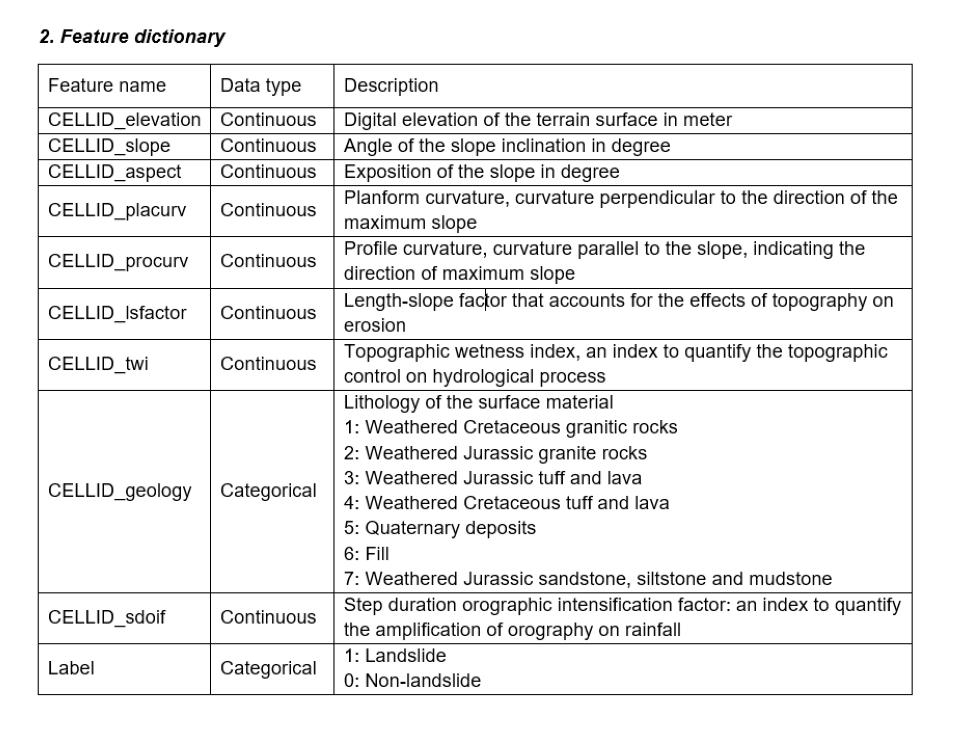

In [5]:
plt.figure(figsize=(6, 5))
img = mpimg.imread('descript.png')
plt.imshow(img)
plt.axis('off')
plt.show()

## 3. EDA + Feature Engineering

In [6]:
train = train.drop(columns='Sample_ID')

In [7]:
def basic_info(df):
    print('DataFrame shape:', df.shape)
    print('Number of misssing values in all DataFrame = %d' % df.isna().sum().sum())
    print('Number of duplicates = %d' % train.duplicated().sum())
    print('Number of columns of each data type:')    
    display(df.dtypes.value_counts())
    display(df.head())
    
basic_info(train)

DataFrame shape: (10864, 226)
Number of misssing values in all DataFrame = 0
Number of duplicates = 32
Number of columns of each data type:


float64    175
int64       51
dtype: int64

1_elevation  2_elevation  3_elevation  4_elevation  5_elevation  \
0          130          129          127          126          123   
1          161          158          155          153          151   
2          149          151          154          156          158   
3           80           78           77           75           73   
4          117          115          114          112          110   

   6_elevation  7_elevation  8_elevation  9_elevation  10_elevation  ...  \
0          126          125          124          122           119  ...   
1          162          159          155          153           151  ...   
2          154          157          158          160           161  ...   
3           80           78           77           75            73  ...   
4          115          113          111          110           108  ...   

   17_sdoif  18_sdoif  19_sdoif  20_sdoif  21_sdoif  22_sdoif  23_sdoif  \
0  1.281779  1.281743  1.281720  1.281684  1.281811  1.281788  1.281752   
1  1.359639  1.359608  1.359587  1.359556  1.359683  1.359662  1.359631   
2  1.365005  1.365025  1.365055  1.365075  1.364937  1.364967  1.364988   
3  1.100708  1.100738  1.100759  1.100789  1.100630  1.100650  1.100680   
4  1.284180  1.284130  1.284056  1.284006  1.284125  1.284050  1.284001   

   24_sdoif  25_sdoif  Label  
0  1.281729  1.281693      0  
1  1.359610  1.359579      1  
2  1.365018  1.365038      0  
3  1.100700  1.100731      0  
4  1.283926  1.283876      0  

[5 rows x 226 columns]

All duplicates in train set (32) have label 1. Since there is a significant disbalance between classes, I won't drop these duplicates

In [8]:
train[train.duplicated()]
# train = train.drop_duplicates()

1_elevation  2_elevation  3_elevation  4_elevation  5_elevation  \
1096           269          268          266          264          261   
1585           290          289          289          290          292   
2154           268          269          271          274          278   
2561           103          102          101          101          102   
3070           335          333          332          331          330   
4030           476          475          474          471          469   
4487           361          363          366          368          371   
5198           241          239          236          232          229   
5384           427          425          421          418          417   
5469            34           34           37           40           42   
5737           553          549          545          541          536   
5861           424          426          429          432          434   
6748           386          388          392          398          402   
6921           486          484          480          476          473   
7506           261          261          260          257          256   
7518           279          281          284          287          288   
7651           145          144          142          141          139   
7962           207          205          202          198          194   
7964           260          264          268          271          275   
8570           249          249          247          244          241   
8744           423          420          418          416          413   
8937           302          303          304          305          306   
8995           139          136          133          130          129   
9087           199          197          199          200          200   
9168           356          356          356          357          356   
9198           409          411          412          413          413   
9269           296          295          294          292          290   
9313           236          236          237          238          238   
9707            66           67           67           66           64   
10011          194          195          196          197          199   
10123          280          279          278          277          276   
10245          116          118          118          119          121   

       6_elevation  7_elevation  8_elevation  9_elevation  10_elevation  ...  \
1096           270          269          266          263           259  ...   
1585           292          292          292          294           295  ...   
2154           271          272          274          277           280  ...   
2561           103          101          100           99            99  ...   
3070           332          330          327          327           326  ...   
4030           479          478          477          476           474  ...   
4487           365          367          370          373           374  ...   
5198           241          239          234          230           228  ...   
5384           430          428          424          421           419  ...   
5469            37           38           39           41            42  ...   
5737           551          547          543          539           534  ...   
5861           421          423          425          428           430  ...   
6748           388          391          394          398           403  ...   
6921           486          483          480          476           471  ...   
7506           263          263          263          260           258  ...   
7518           280          282          285          287           289  ...   
7651           144          143          142          140           138  ...   
7962           205          202          199          196           193  ...   
7964           259          262          267

In [9]:
basic_info(test)

DataFrame shape: (5430, 226)
Number of misssing values in all DataFrame = 0
Number of duplicates = 32
Number of columns of each data type:


float64    175
int64       51
dtype: int64

Sample_ID  1_elevation  2_elevation  3_elevation  4_elevation  5_elevation  \
0      10865          111          109          109          110          112   
1      10866          189          187          186          185          185   
2      10867           38           37           38           40           43   
3      10868          134          136          137          138          140   
4      10869          340          340          340          340          341   

   6_elevation  7_elevation  8_elevation  9_elevation  ...  16_sdoif  \
0          117          114          113          112  ...  1.310084   
1          187          186          184          183  ...  1.332918   
2           37           37           37           39  ...  1.238290   
3          132          133          134          136  ...  1.300902   
4          336          336          335          336  ...  1.355660   

   17_sdoif  18_sdoif  19_sdoif  20_sdoif  21_sdoif  22_sdoif  23_sdoif  \
0  1.310153  1.310199  1.310267  1.310313  1.309963  1.310031  1.310077   
1  1.332943  1.332960  1.332985  1.333002  1.332823  1.332849  1.332865   
2  1.238371  1.238492  1.238572  1.238693  1.238087  1.238167  1.238288   
3  1.300895  1.300890  1.300883  1.300879  1.300930  1.300923  1.300919   
4  1.355597  1.355503  1.355440  1.355345  1.355583  1.355520  1.355426   

   24_sdoif  25_sdoif  
0  1.310146  1.310192  
1  1.332890  1.332907  
2  1.238369  1.238490  
3  1.300912  1.300907  
4  1.355363  1.355268  

[5 rows x 226 columns]

There are no NaNs in train and test data

Let's look at the proportion between train objects with positive (landslide occured) and negative (no landslide occured) labels.

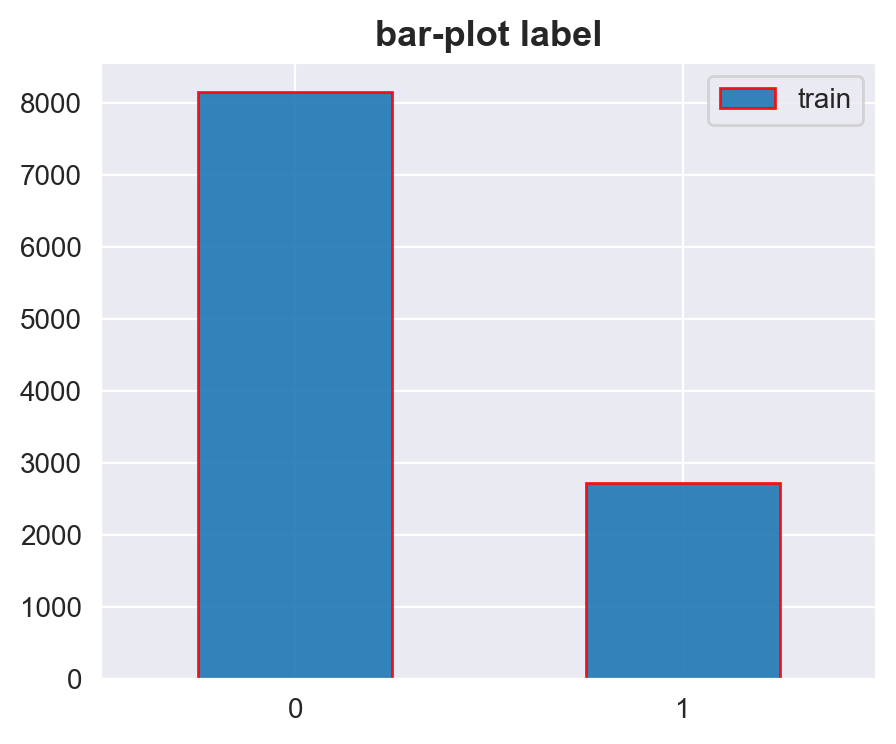

In [11]:
plt.figure(figsize=(5, 4))
train['Label'].value_counts().sort_index() \
              .plot(kind='bar', alpha=0.9, edgecolor='red', label='train')
plt.title('bar-plot label', weight='bold', fontsize=13)
plt.legend()
plt.xticks(rotation=0)
plt.show()

In [12]:
train['Label'].mean()

0.25

In [13]:
def basic_cols(df, feature_name):
    return [x for x in df.columns if x.endswith(feature_name)]


elevation_cols = basic_cols(train, 'elevation')
slope_cols = basic_cols(train, 'slope')
aspect_cols = basic_cols(train, 'aspect')
placurv_cols = basic_cols(train, 'placurv')
procurv_cols = basic_cols(train, 'procurv')
lsfactor_cols = basic_cols(train, 'lsfactor')
twi_cols = basic_cols(train, 'twi')
geology_cols = basic_cols(train, 'geology')
sdoif_cols = basic_cols(train, 'sdoif')

In [14]:
# Let's make a feature which shows, if lithology is the same on whole object area 
train['mono_geology'] = (train[geology_cols].mean(axis=1) == \
                         train[geology_cols].mean(axis=1).astype(int)).astype(int)

test['mono_geology'] = (test[geology_cols].mean(axis=1) == \
                        test[geology_cols].mean(axis=1).astype(int)).astype(int)

In [15]:
# Let's make a feature which shows the difference between highest and lowest point
train['delta_elevation'] = train[elevation_cols].max(axis=1) - \
                           train[elevation_cols].min(axis=1)

test['delta_elevation'] = test[elevation_cols].max(axis=1) - \
                          test[elevation_cols].min(axis=1)

In [14]:
# train['max_slope'] = train[slope_cols].max(axis=1)
# train['min_slope'] = train[slope_cols].min(axis=1)

# test['max_slope'] = test[slope_cols].max(axis=1)
# test['min_slope'] = test[slope_cols].min(axis=1)

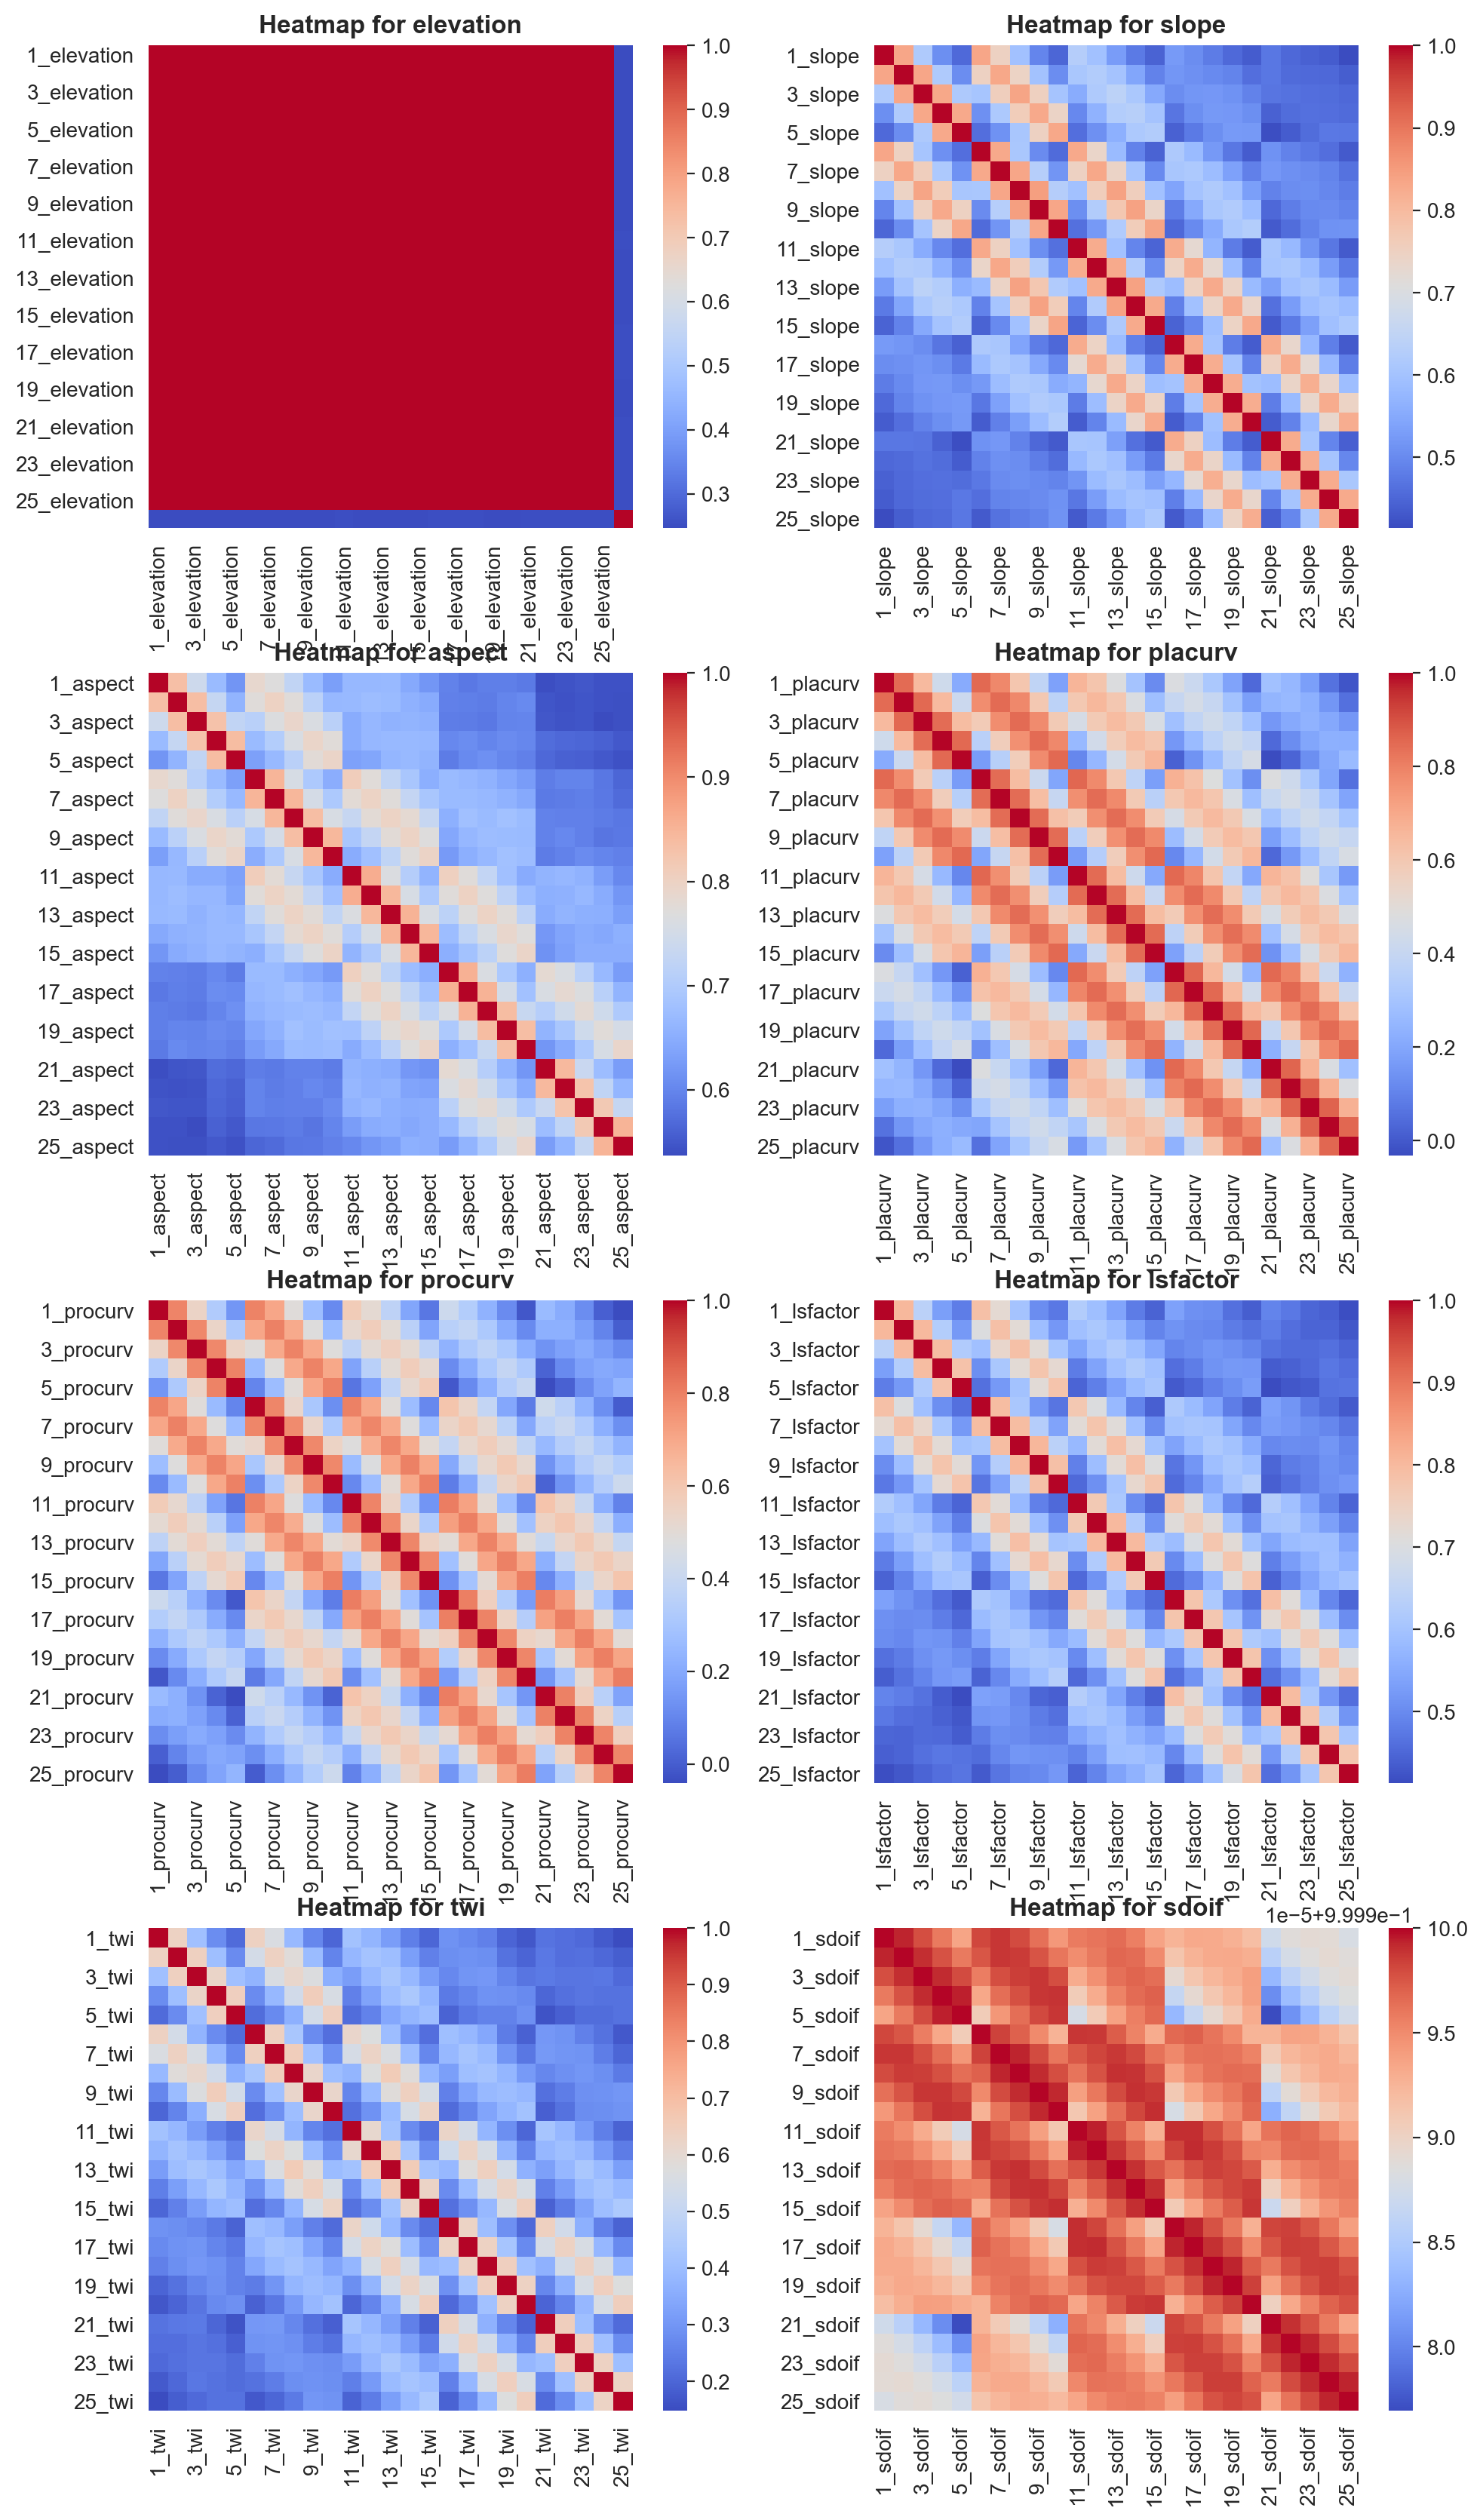

In [22]:
# Let's try to make a heatmap, but we'll see that heatmaps
# are non-informative due to high correlation between features from one group
main_cols = ['elevation', 'slope', 'aspect', 'placurv', 
             'procurv', 'lsfactor', 'twi', 'sdoif'] 

fig, ax = plt.subplots(4, 2, figsize=(9, 16))
col_l = np.array(main_cols).reshape(4, 2)

for i in range(4):
    for j in range(2):
        c = col_l[i][j]
        sns.heatmap(train[[x for x in train.columns if x.endswith(c)]].corr(), 
                    cmap='coolwarm', ax=ax[i][j])
        ax[i][j].set_title(f'Heatmap for {c}', weight='bold', fontsize=12)

        
fig.subplots_adjust(left=0.01, right=0.99, 
                    bottom=0.01, top=0.99,
                    wspace=0.2, hspace=0.3)
plt.show()

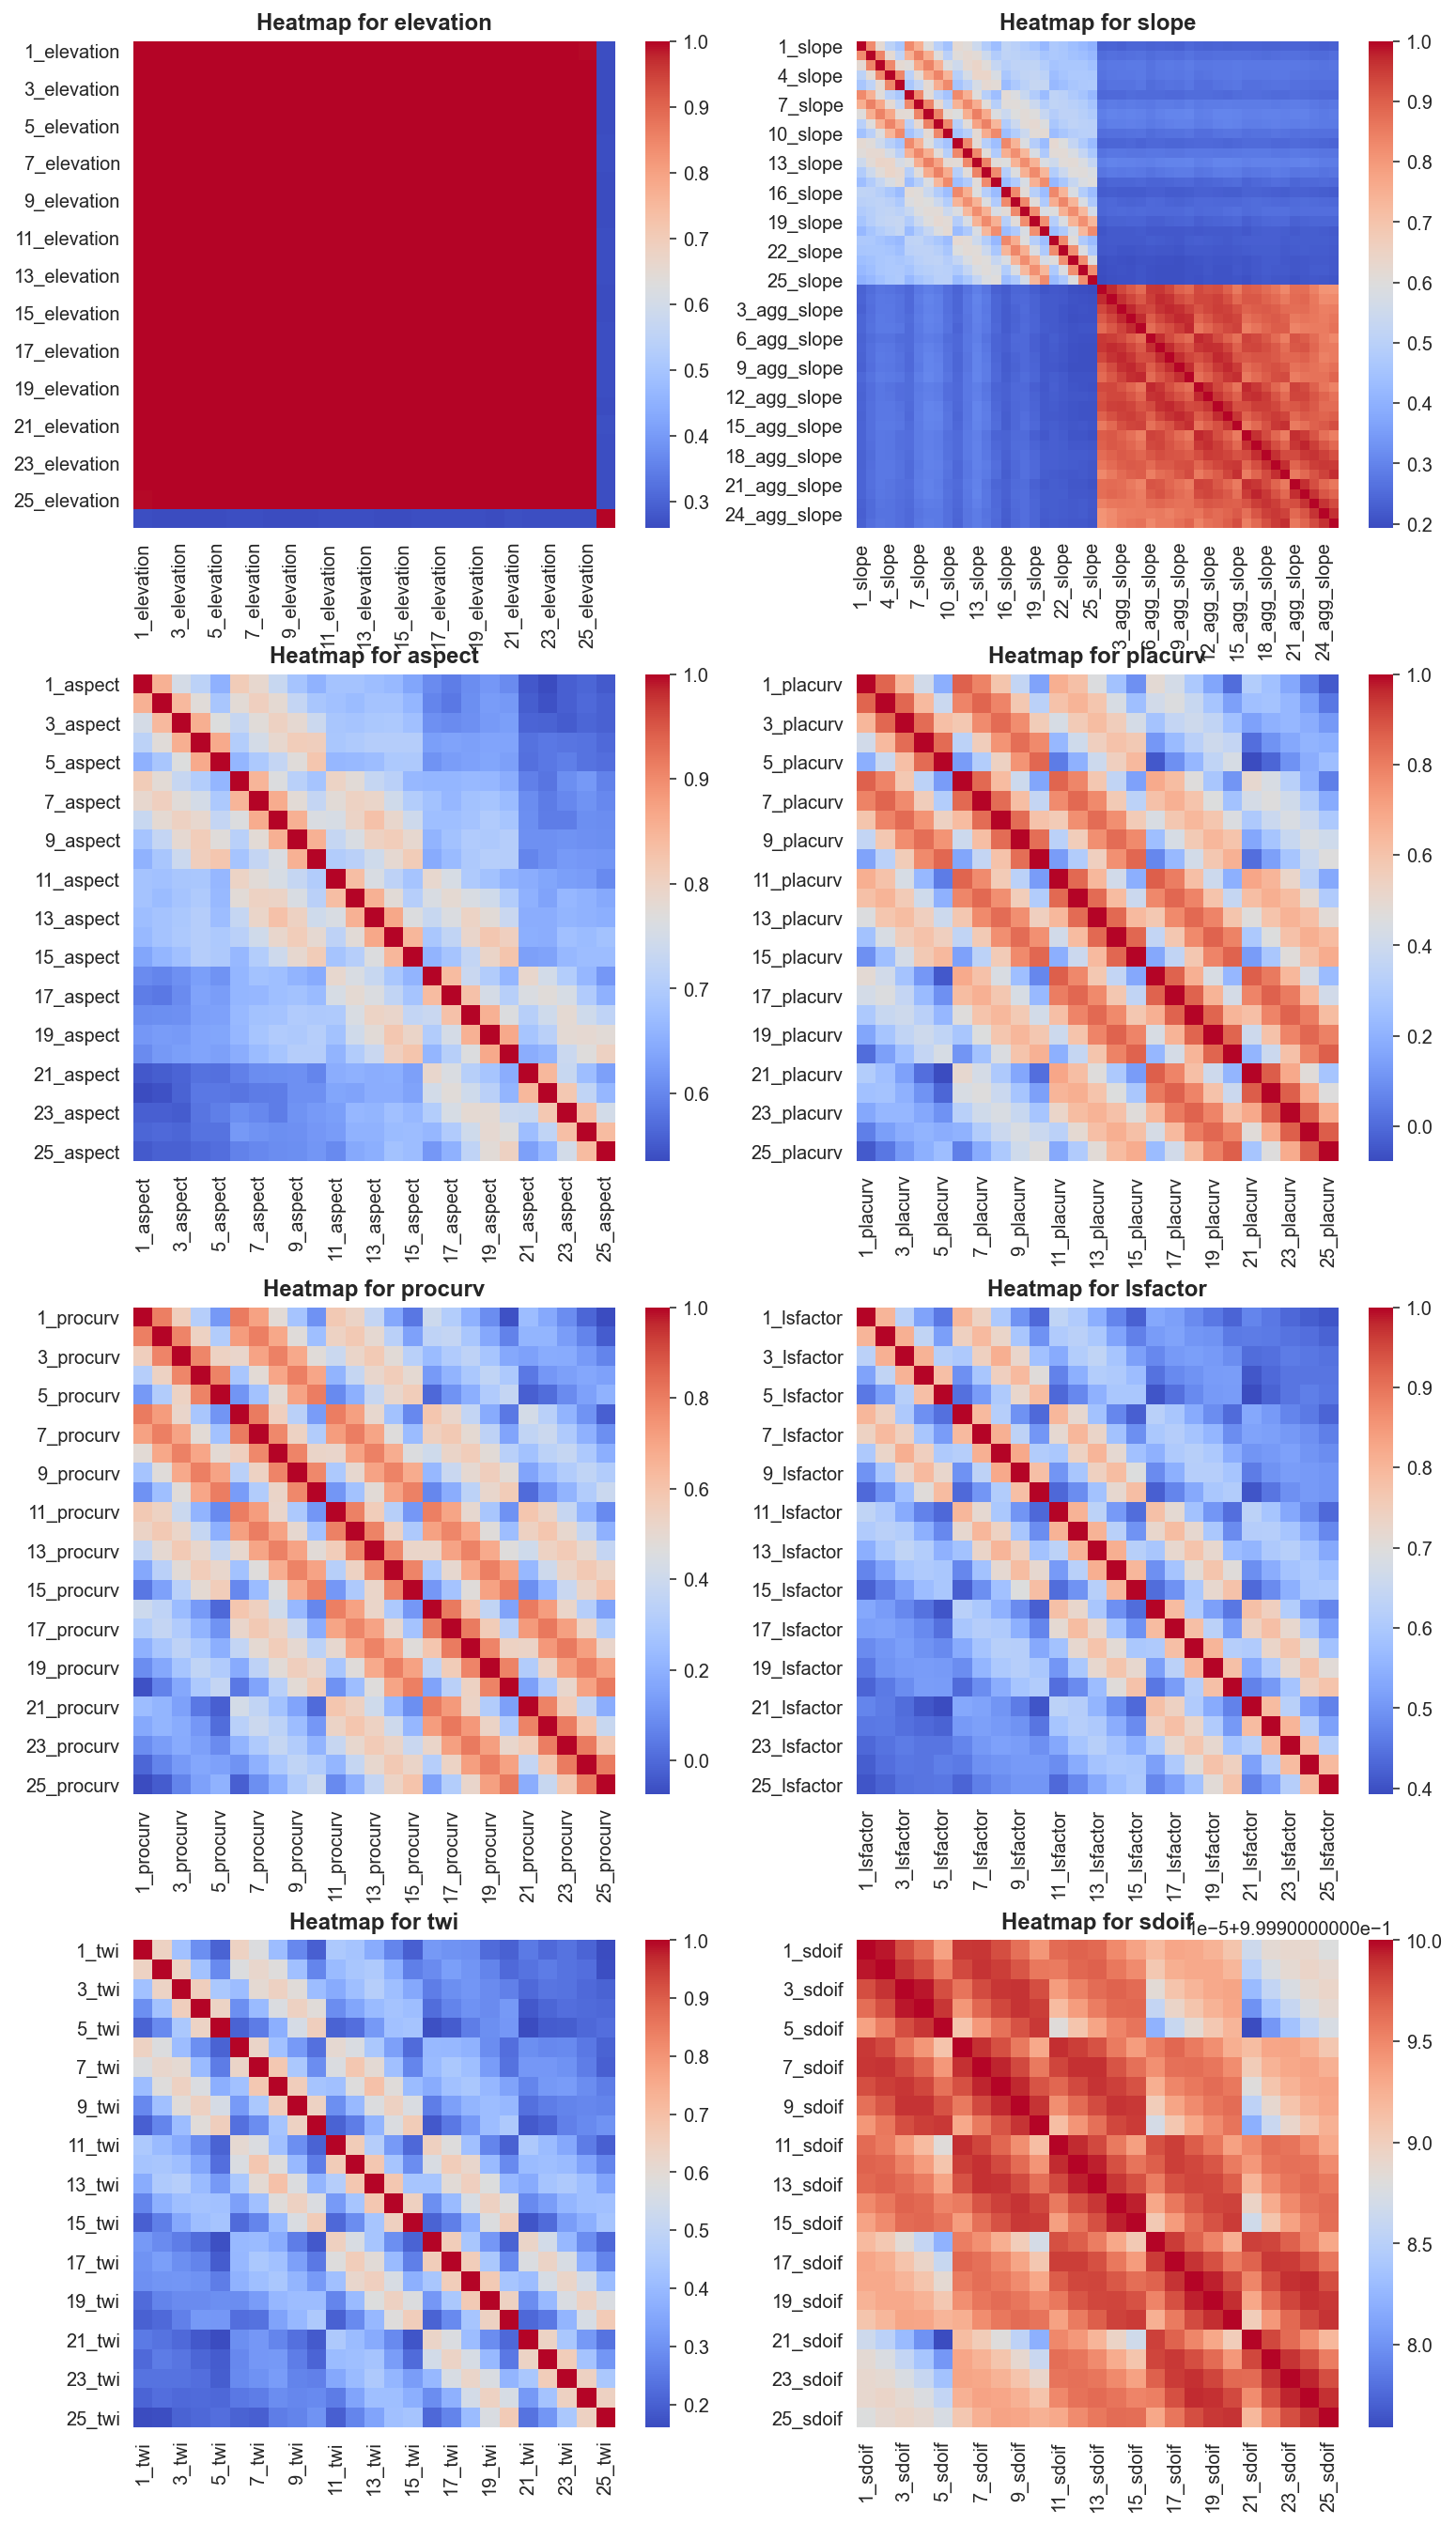

In [14]:
# same for test
fig, ax = plt.subplots(4, 2, figsize=(10, 18))

for i in range(4):
    for j in range(2):
        c = col_l[i][j]
        sns.heatmap(test[[x for x in test.columns if x.endswith(c)]].corr(), 
                    cmap='coolwarm', ax=ax[i][j])
        ax[i][j].set_title(f'Heatmap for {c}', weight='bold', fontsize=12)

        
fig.subplots_adjust(left=0.01, right=0.99, 
                    bottom=0.01, top=0.99,
                    wspace=0.2, hspace=0.3)
plt.show()

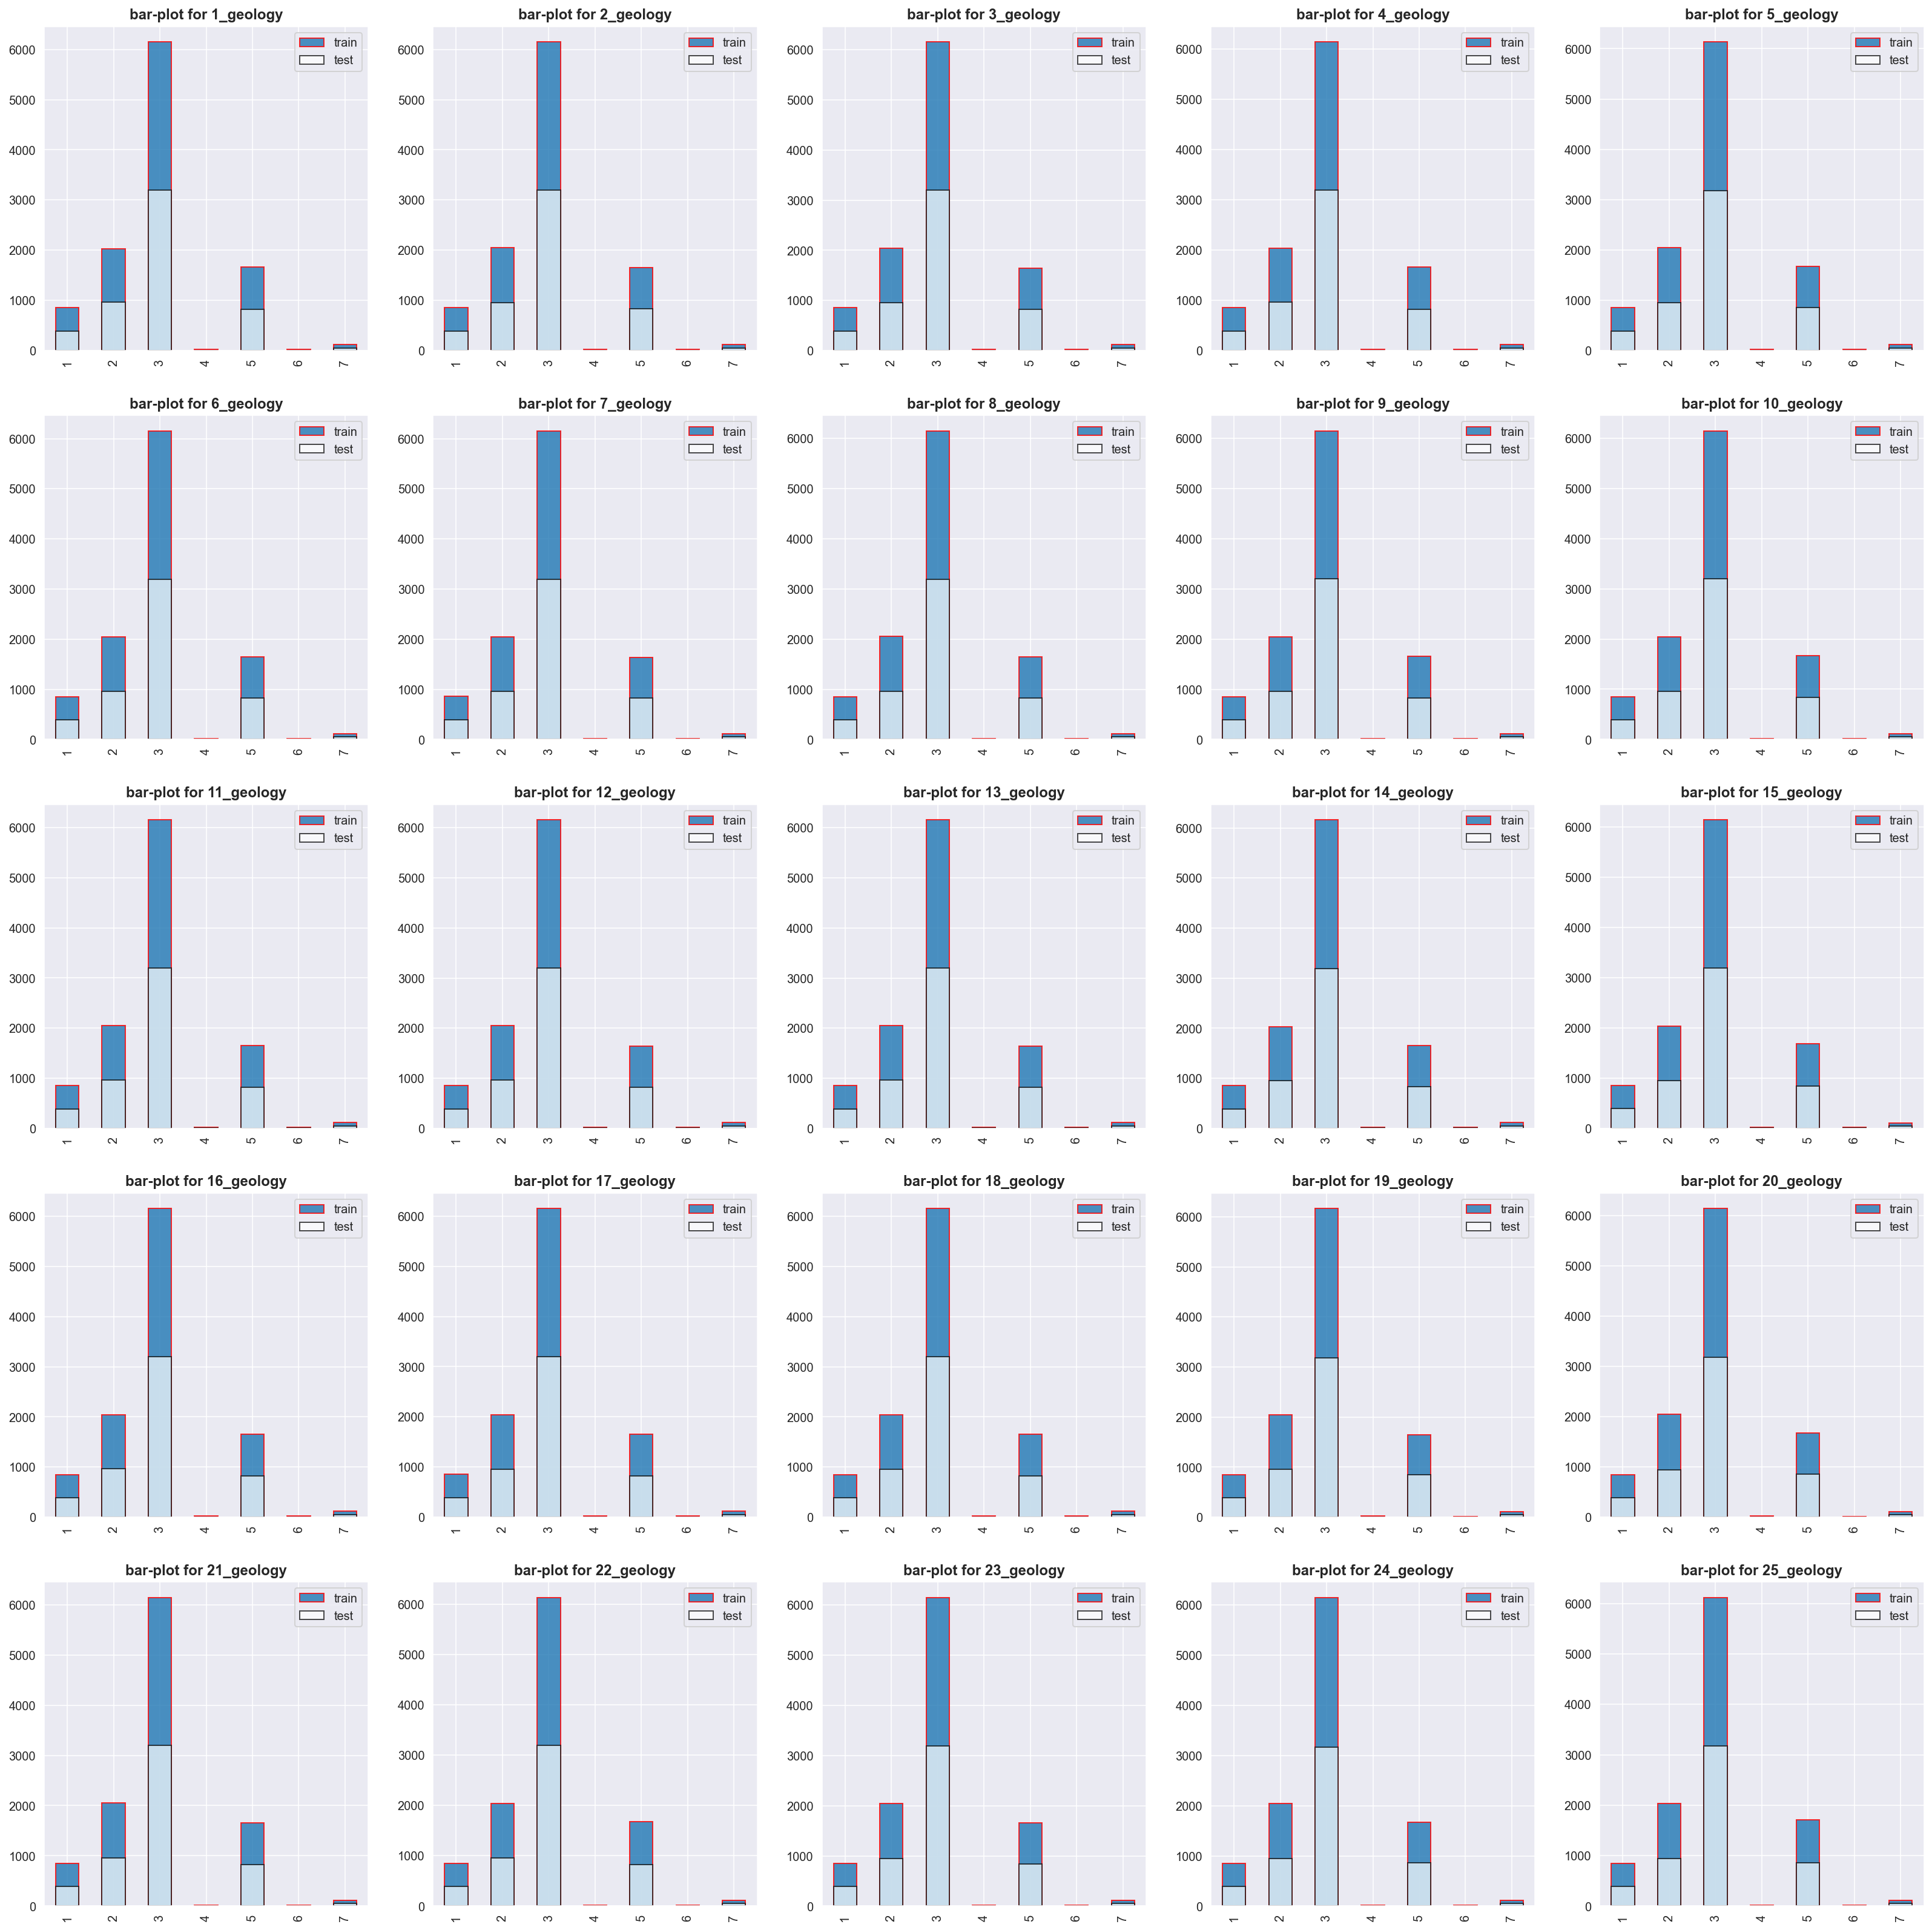

In [26]:
fig, ax = plt.subplots(5, 5, figsize=(22, 22))
col_l = np.array(geology_cols).reshape(5, 5)

for i in range(5):
    for j in range(5):
        c = col_l[i][j]
        train[c].value_counts().sort_index() \
                .plot(kind='bar', ax=ax[i][j], alpha=0.8, edgecolor='red', label='train')
        test[c].value_counts().sort_index() \
               .plot(kind='bar', ax=ax[i][j], alpha=0.7, color='white', edgecolor='black', label='test')
        ax[i][j].set_title(f'bar-plot for {c}', weight='bold', fontsize=12)
        ax[i][j].legend()

        
fig.subplots_adjust(left=0.01, right=0.99, 
                    bottom=0.01, top=0.99,
                    wspace=0.2, hspace=0.2)
plt.show()

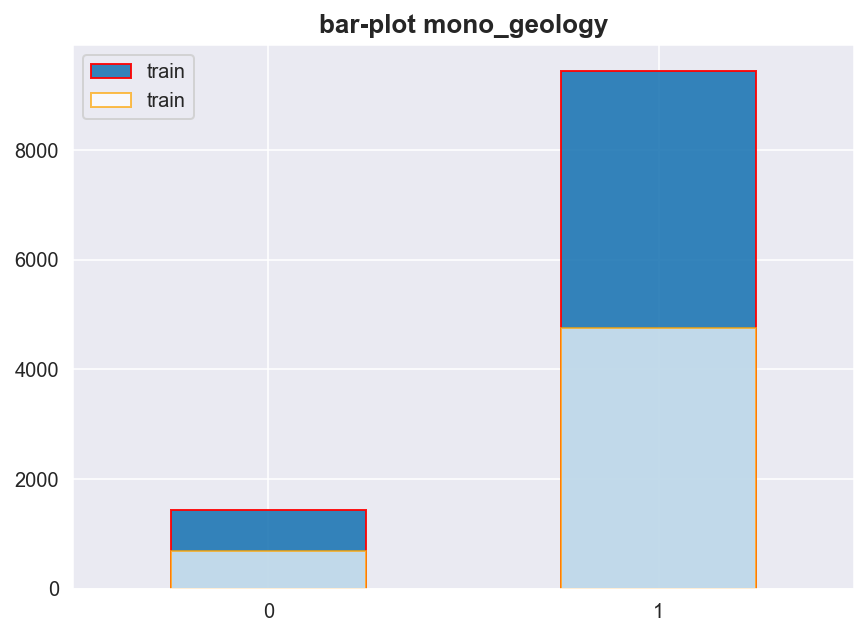

In [14]:
plt.figure(figsize=(7, 5))
train['mono_geology'].value_counts().sort_index() \
                     .plot(kind='bar', alpha=0.9, edgecolor='red', label='train')
test['mono_geology'].value_counts().sort_index() \
                    .plot(kind='bar', alpha=0.7, color='white', edgecolor='orange', label='train')
plt.title('bar-plot mono_geology', weight='bold', fontsize=13)
plt.legend()
plt.xticks(rotation=0)
plt.show()

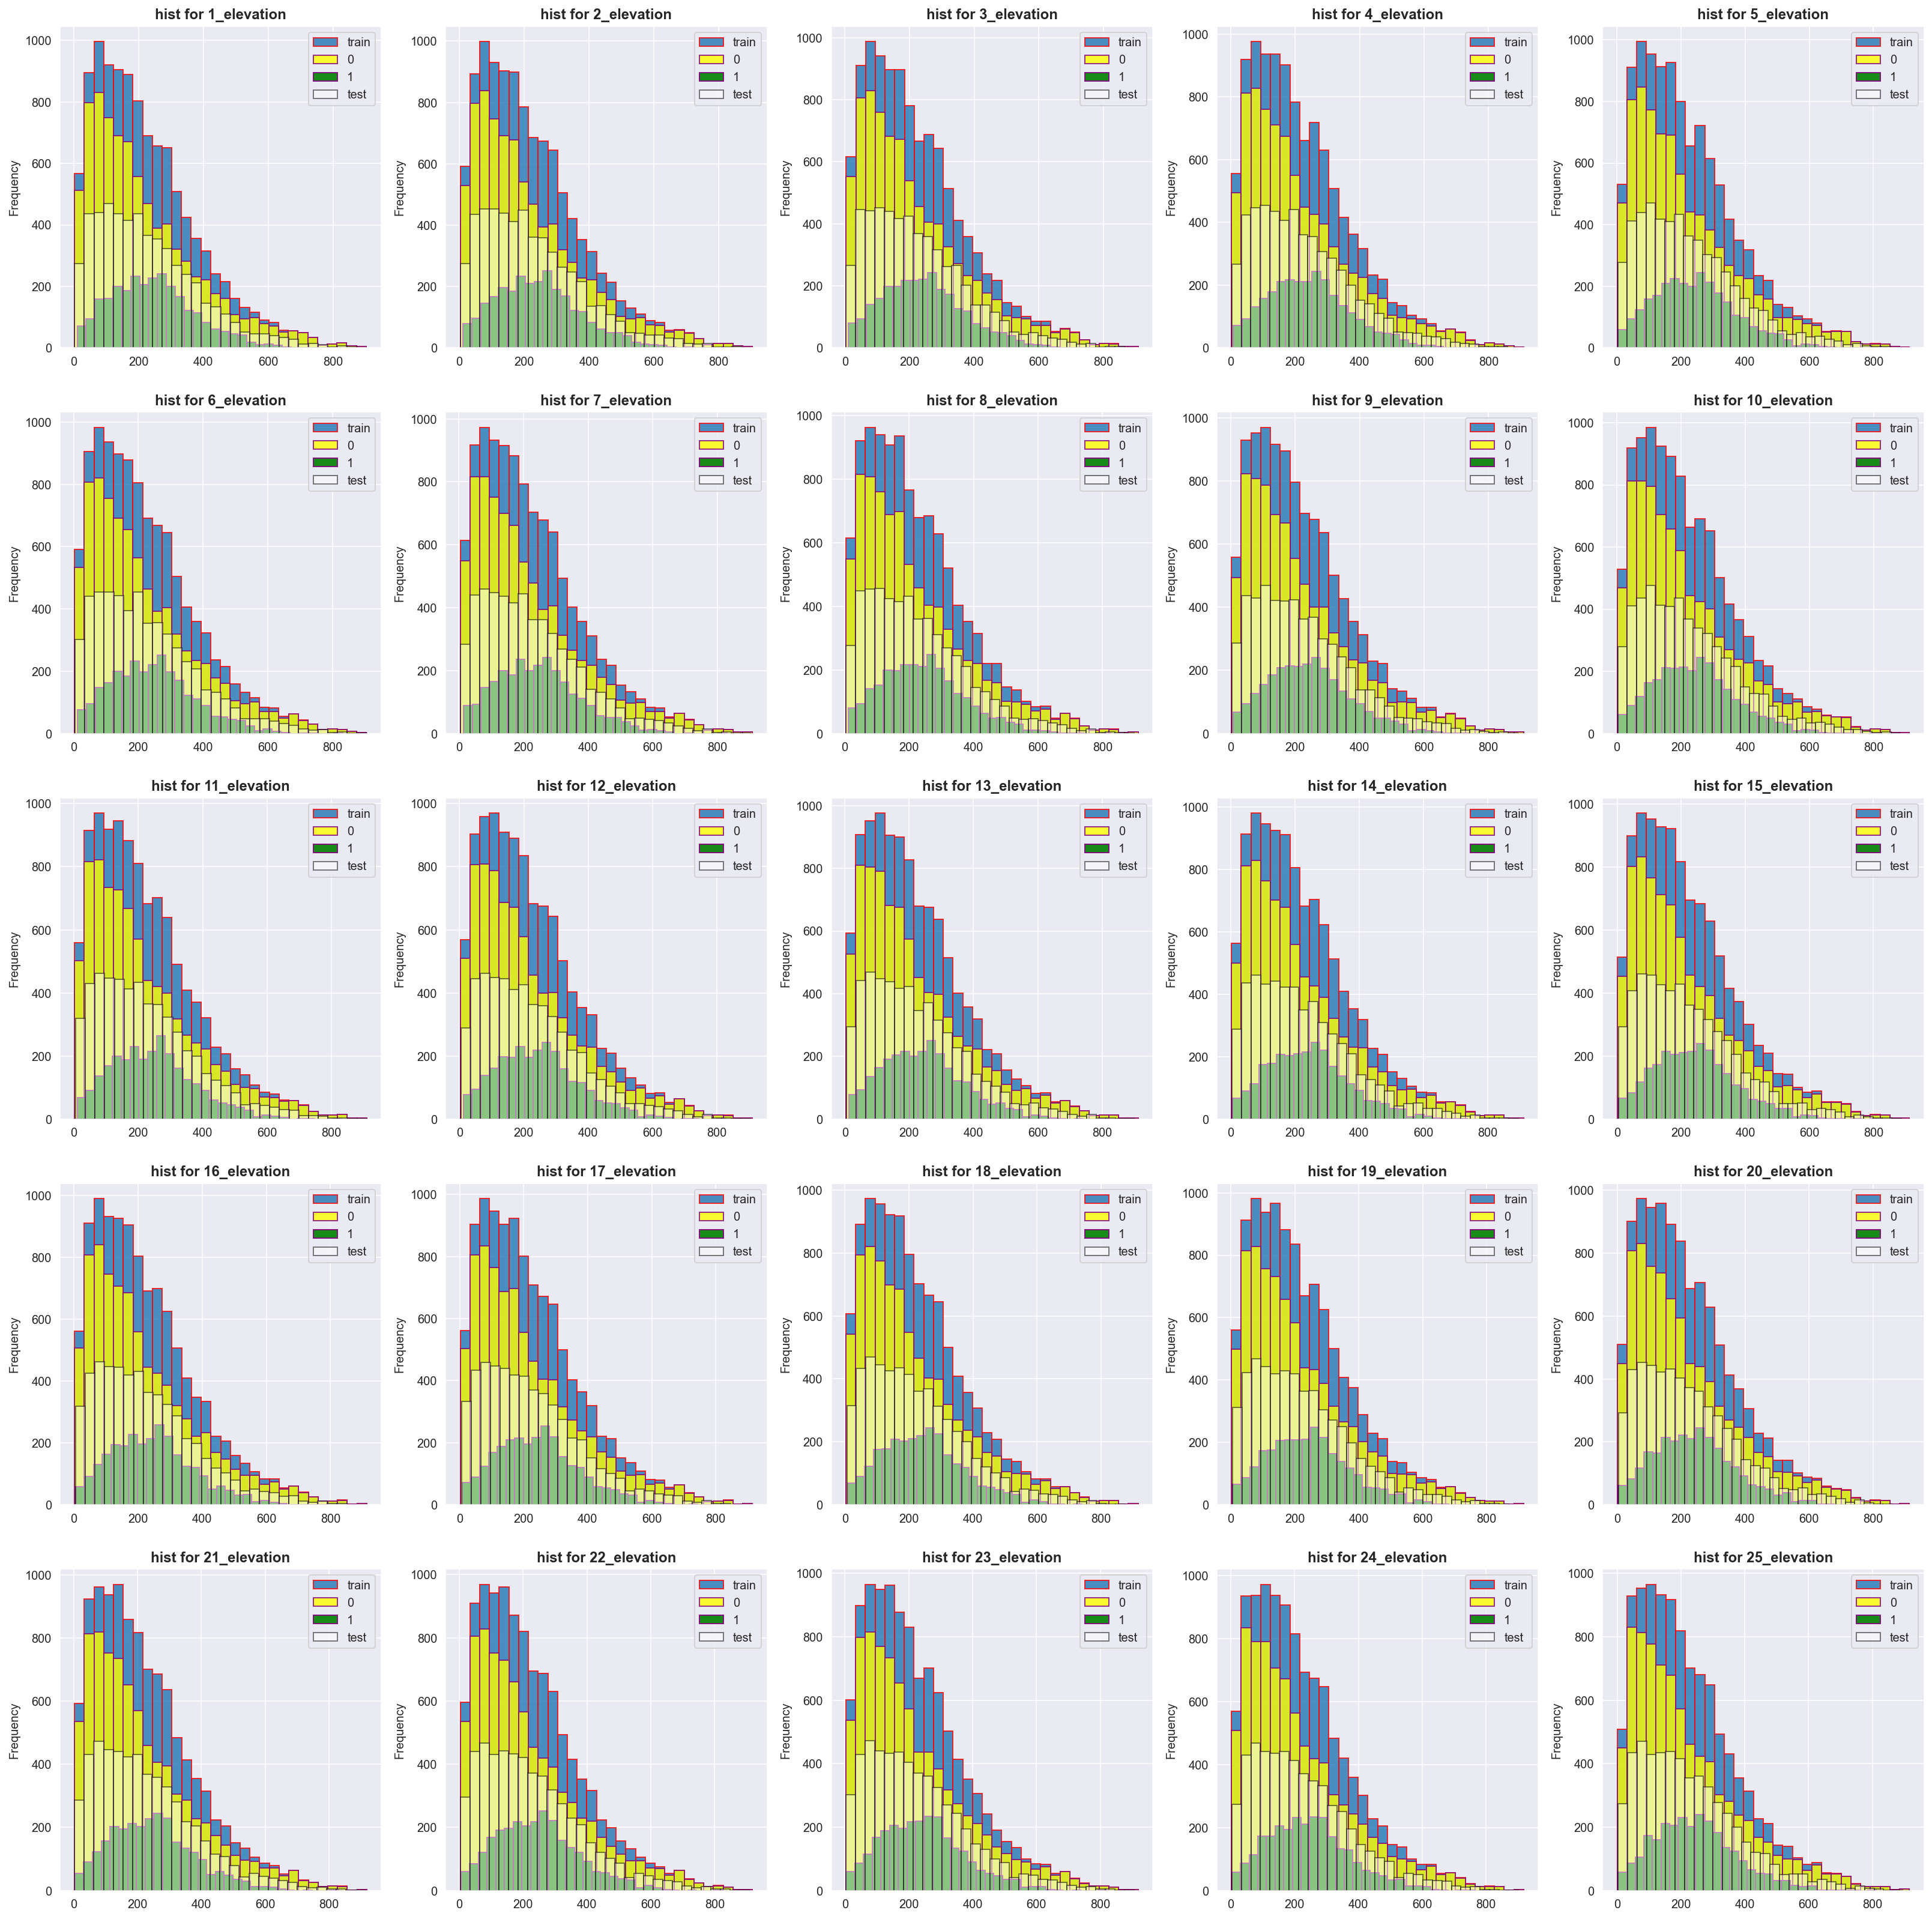

In [12]:
# plot hists comparing distributions on train and test
def plt_hists(df1, df2, cols, bins=30):
    fig, ax = plt.subplots(5, 5, figsize=(22, 22))
    col_l = np.array(cols).reshape(5, 5)

    for i in range(5):
        for j in range(5):
            c = col_l[i][j]
            df1[c].plot(kind='hist', ax=ax[i][j], alpha=0.8, bins=bins, 
                        edgecolor='red', label='train')
            df1[df1['Label'] == 0][c].plot(kind='hist', ax=ax[i][j], alpha=0.8, bins=30, 
                                           color='yellow', edgecolor='purple', label='0')
            df1[df1['Label'] == 1][c].plot(kind='hist', ax=ax[i][j], alpha=0.9, bins=30, 
                                           color='green', edgecolor='purple', label='1')
            df2[c].plot(kind='hist', ax=ax[i][j], alpha=0.5, bins=bins, 
                        color='white', edgecolor='black', label='test')
            ax[i][j].set_title(f'hist for {c}', weight='bold', fontsize=12)
            ax[i][j].legend()


    fig.subplots_adjust(left=0.01, right=0.99, 
                        bottom=0.01, top=0.99,
                        wspace=0.2, hspace=0.2)
    plt.show()
    
    
plt_hists(train, test, elevation_cols)

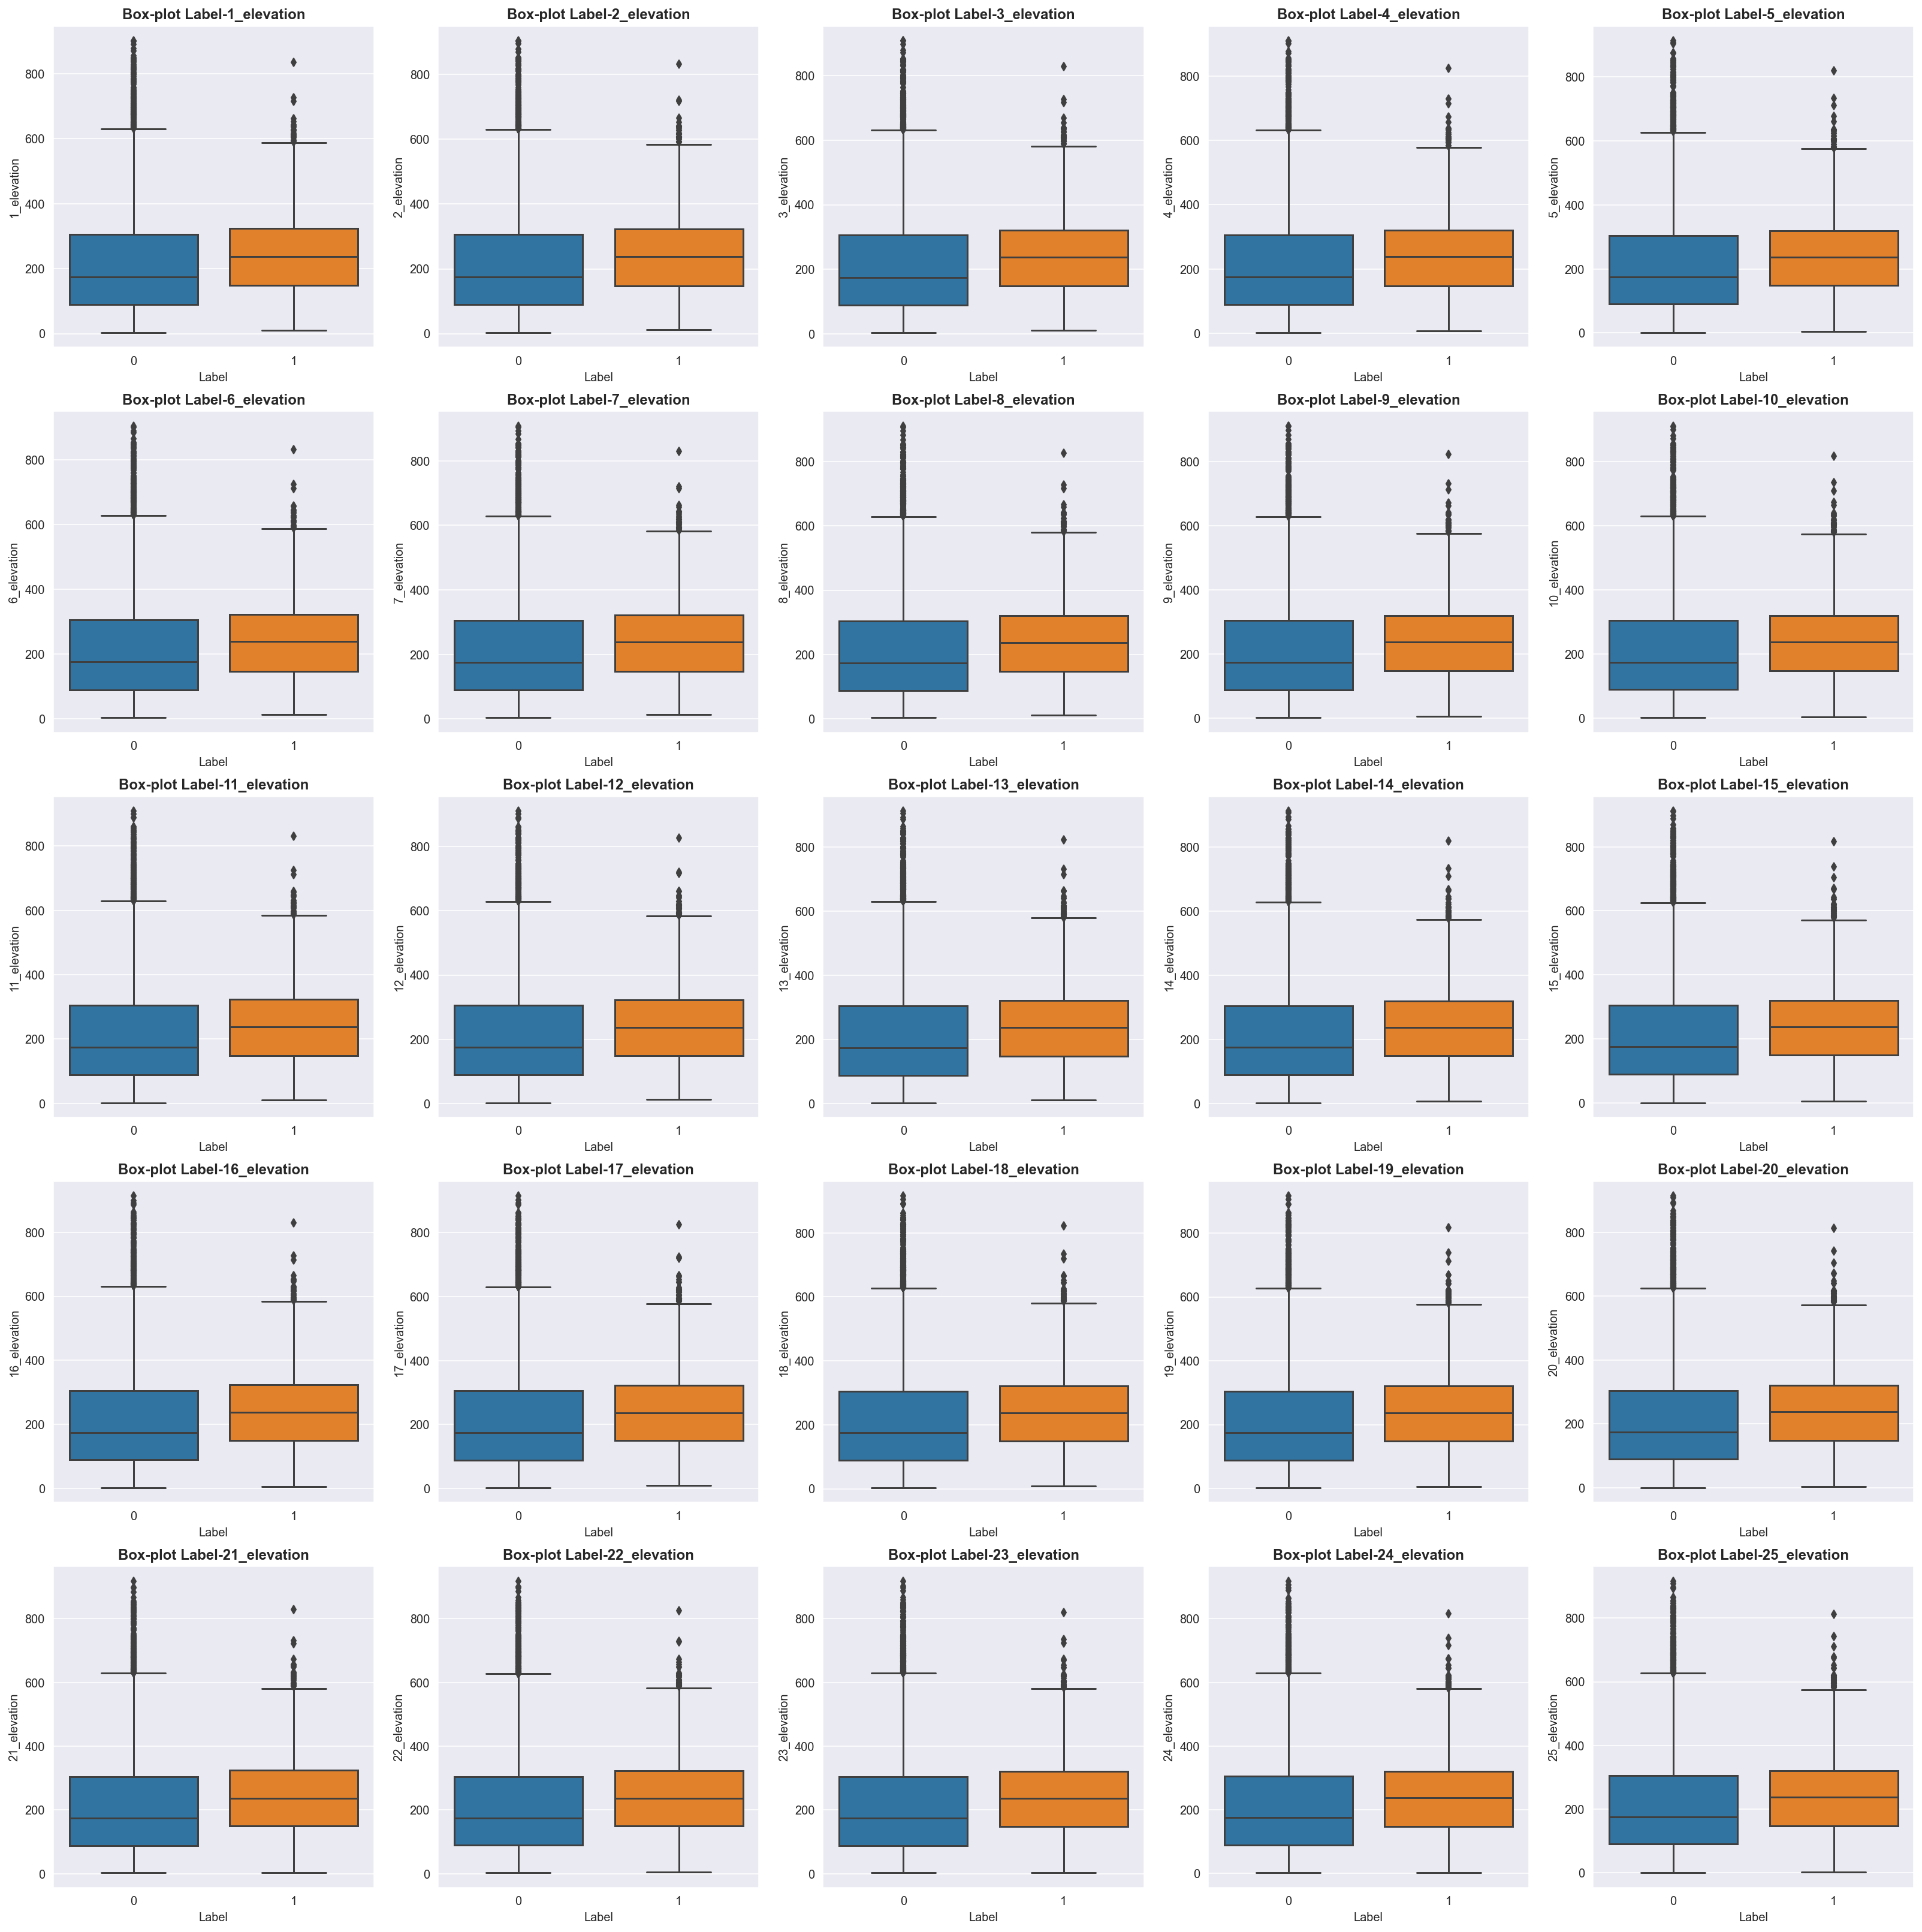

In [13]:
def box_plt(df, col_name, ax):
    sns.boxplot(x='Label', y=col_name, data=df, ax=ax)
    ax.set_title(f'Box-plot Label-{col_name}', 
                 fontsize=12, weight='bold')
    
    
def plt_boxs(df, cols):
    fig, ax = plt.subplots(5, 5, figsize=(22, 22))
    col_l = np.array(cols).reshape(5, 5)

    for i in range(5):
        for j in range(5):
            c = col_l[i][j]
            box_plt(df, c, ax[i][j])


    fig.subplots_adjust(left=0.01, right=0.99, 
                        bottom=0.01, top=0.99,
                        wspace=0.2, hspace=0.2)
    plt.show()
    
    
plt_boxs(train, elevation_cols)

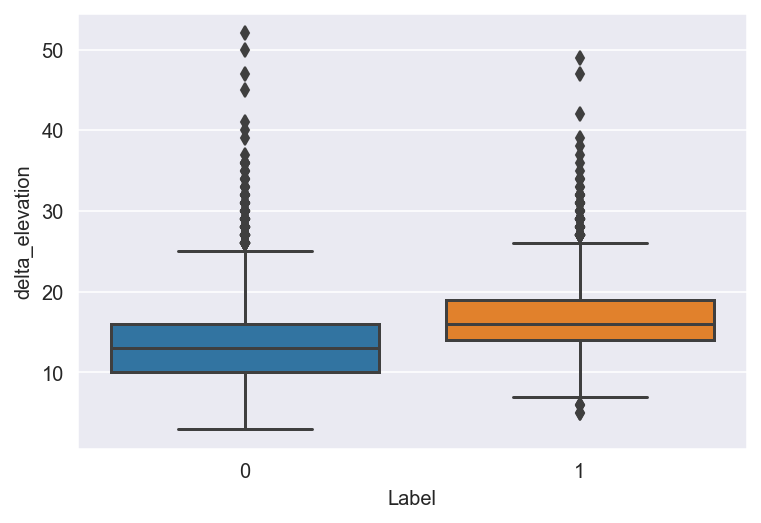

In [16]:
sns.boxplot(x='Label', y='delta_elevation', data=train)
plt.show()

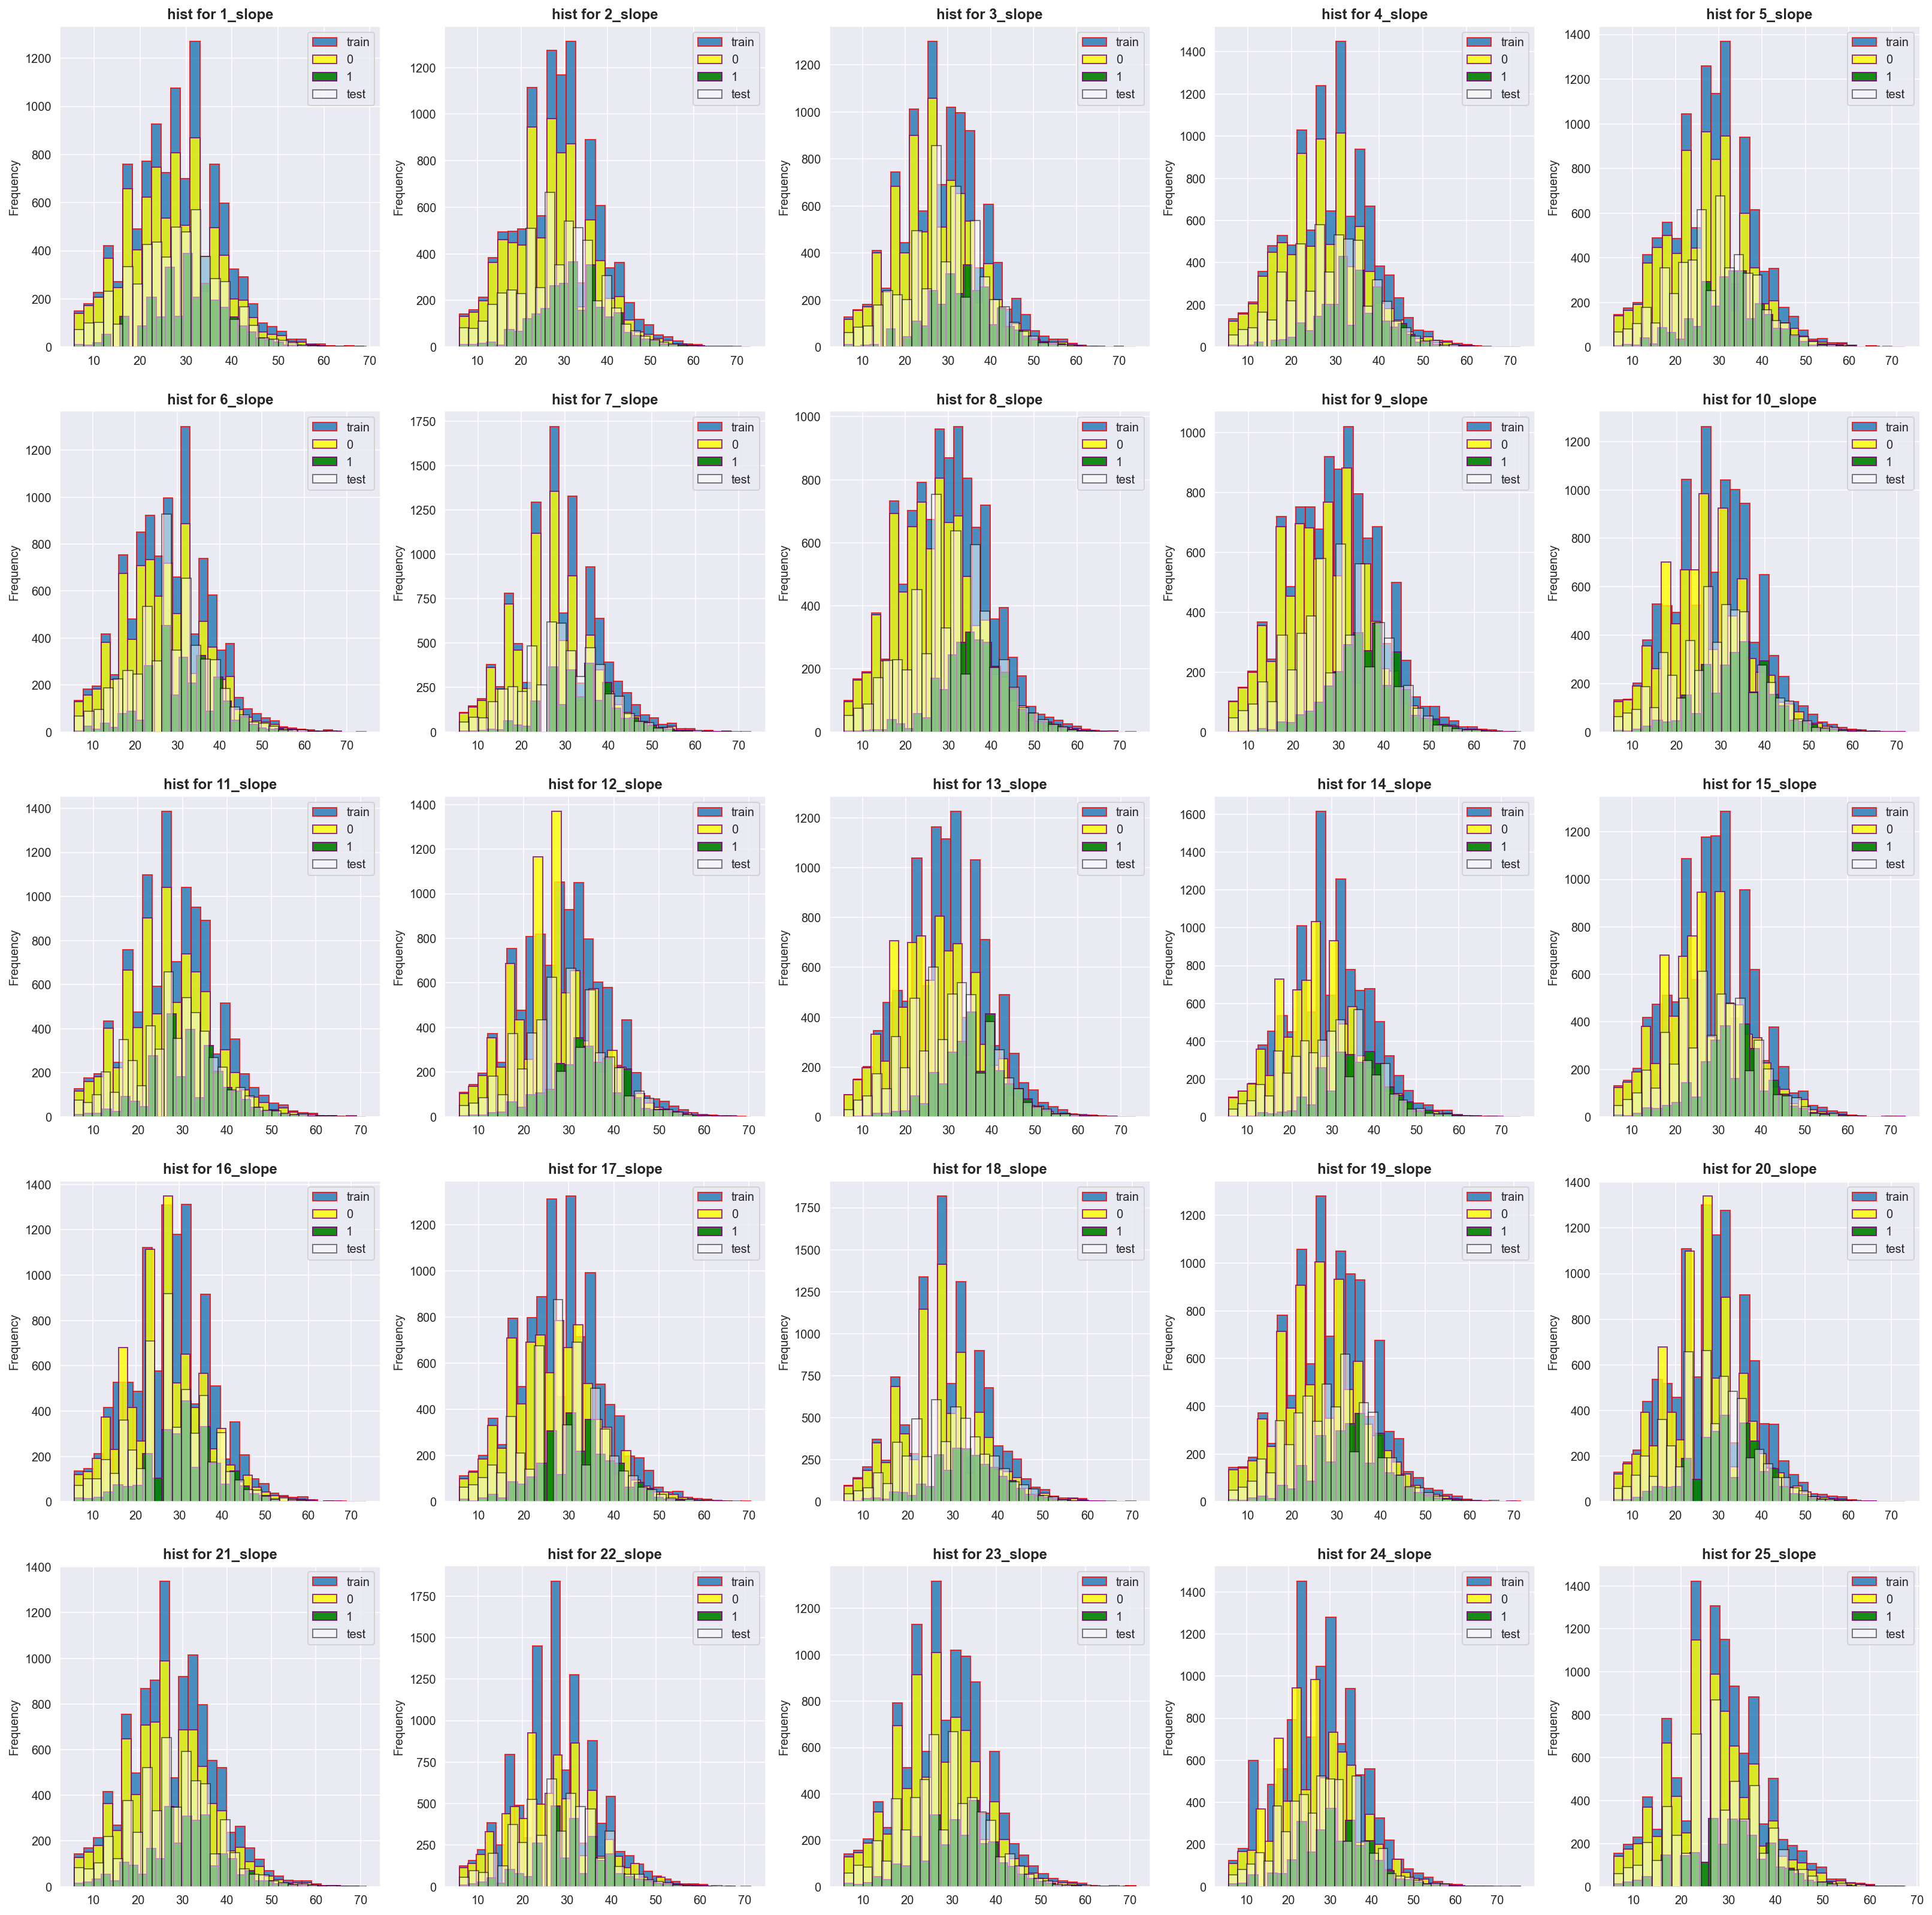

In [28]:
plt_hists(train, test, slope_cols)

**Visual analysis doesn't give any real advantage in this task (at least I couldn't squeeze anything out of it), so I'll just comment code for visualization for other groups of features just to make this notebook a bit more shorter.**

In [81]:
# plt_boxs(train, slope_cols)

In [82]:
# plt_hists(train, test, aspect_cols)
# plt_boxs(train, aspect_cols)

In [84]:
# plt_hists(train, test, placurv_cols)
# plt_boxs(train, placurv_cols)

In [86]:
# plt_hists(train, test, procurv_cols)
# plt_hists(train, test, lsfactor_cols)

In [88]:
# plt_hists(train, test, twi_cols)

In [89]:
# plt_hists(train, test, sdoif_cols)

In [80]:
# train[['20_geology', 'Label']].groupby(['20_geology', 'Label']).agg({'20_geology': 'count'})

In [16]:
# Попробуем заиспользовать счетчики
def mean_encoding(df, cols, target, alpha=0.05, train=train):
    for c in cols:
        d = {}
        for k in train[c].unique():
            y_mean_k = train[train[c] == k][target].mean()
            y_mean = train[target].mean()
            count_k = train[c].value_counts()[k]
            d[k] = (y_mean_k * count_k + y_mean * alpha) / (count_k + alpha)
        df[c + '_mte'] = df[c].apply(lambda x: d[x])
    return df


train = mean_encoding(train, geology_cols, 'Label')
test = mean_encoding(test, geology_cols, 'Label')

## 4. ML-part

In [17]:
X = train.drop(columns=['Label'])
y = train['Label']

**Class imbalance is huge so using undersampling could be a good idea (it actually is)**

In [18]:
no_slide = list(y[y == 0].index)
np.random.seed(42)
to_drop = np.random.choice(no_slide, size=int(len(no_slide) * 0.33), replace=False)

In [19]:
X = X.drop(index=to_drop)
y = y.drop(index=to_drop)

In [21]:
print(f'{y.mean():.3f}')

0.332


More significant undersampling resulted in lower quality

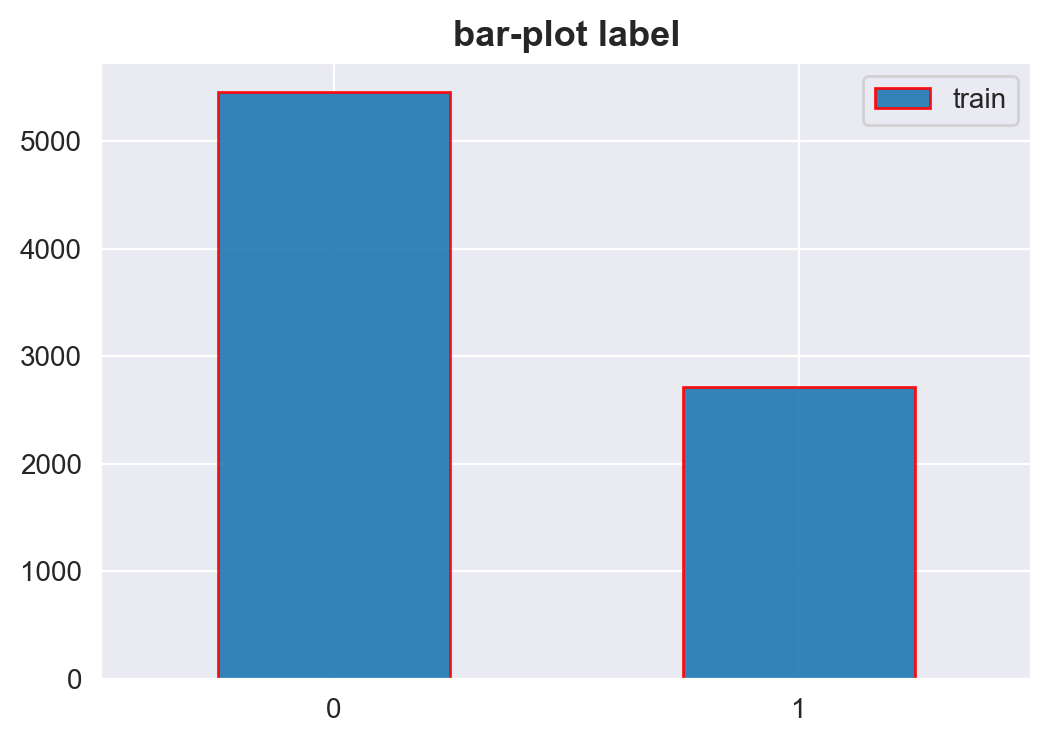

In [22]:
plt.figure(figsize=(6, 4))
y.value_counts().sort_index() \
                .plot(kind='bar', alpha=0.9, edgecolor='red', label='train')
plt.title('bar-plot label', weight='bold', fontsize=13)
plt.legend()
plt.xticks(rotation=0)
plt.show()

We'll drop features which were considered useless by most of the models on early iterations of this solution. All geology features are droped here and replaced with mean target encoded versions.

In [23]:
to_drop = [ '13_placurv',
 '20_placurv',
 '4_aspect',
 '23_procurv',
 '8_procurv',
 '7_aspect',
 '21_placurv',
 '6_procurv',
 '2_geology',
 '3_procurv',
 '22_lsfactor',
 '12_aspect',
 '5_aspect',
 '25_placurv',
 '4_slope',
 '12_twi',
 '14_aspect',
 '21_slope',
 '25_lsfactor',
 '2_lsfactor',
 '23_aspect',
 '18_aspect',
 '7_lsfactor',
 '16_aspect',
 '3_placurv',
 '21_aspect',         
 '8_geology',
 '24_geology',
 '19_geology',
 'mono_geology'
]
    
for c in X.columns:
    if c in to_drop:
        X = X.drop(columns=c)       

elevation_cols = basic_cols(X, 'elevation')
slope_cols = basic_cols(X, 'slope')
aspect_cols = basic_cols(X, 'aspect')
placurv_cols = basic_cols(X, 'placurv')
procurv_cols = basic_cols(X, 'procurv')
lsfactor_cols = basic_cols(X, 'lsfactor')
twi_cols = basic_cols(X, 'twi')
geology_cols = basic_cols(X, 'geology')
sdoif_cols = basic_cols(X, 'sdoif')

X = X.drop(columns=geology_cols)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
numeric = [x for x in X.columns if not x.endswith('geology')]
categoric = [x for x in X.columns if x.endswith('geology')]

In [27]:
numeric = numeric[:-25]

In [28]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric)
], remainder='passthrough')

X_train_transf = column_transformer.fit_transform(X_train)
X_val_transf = column_transformer.transform(X_val)
X_test_transf = column_transformer.transform(test.drop(columns=['Sample_ID'] + to_drop))

In [29]:
print("Number of features before transformation:", X_train.shape[1])
print("Number of features after transformation:", X_train_transf.shape[1])

Number of features before transformation: 201
Number of features after transformation: 201


In [35]:
def print_metrics(model, y_val, X_val, y_pred):
    '''
    Handy function for printing all relevant metrics.
    '''
    print('accuracy = {:.5f}'.format(accuracy_score(y_val, y_pred)))
    print('F1 score = {:.5f}'.format(f1_score(y_val, y_pred)))

    precision, recall, thresholds = metrics.precision_recall_curve(y_val, 
                                                                   model.predict_proba(X_val)[:, 1])
    fpr, tpr, thresholds = metrics.roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    print('AUC-PR = %.5f' % metrics.auc(recall, precision))
    print('AUC-ROC = %.5f' % metrics.auc(fpr, tpr))
    cm = confusion_matrix(y_val, model.predict(X_val))
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(3, 3))
    # Deactivate default colorbar
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, colorbar=False)
    sns.set_style('darkgrid')
    plt.show()

In [31]:
def model_fit_predict(model, X_train, y_train, X_val, y_val):
    '''
    Handy function for fitting model and 
    printing all relevant metrics.
    '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print('F1 score (train) = {:.5f}'.format(f1_score(y_train, model.predict(X_train))))
    print_metrics(model, y_val, X_val, y_pred)
    return model

### 4.1. Logistic Regression (baseline model)

F1 score (train) = 0.70770
accuracy = 0.80196
F1 score = 0.68966
AUC-PR = 0.73967
AUC-ROC = 0.85534


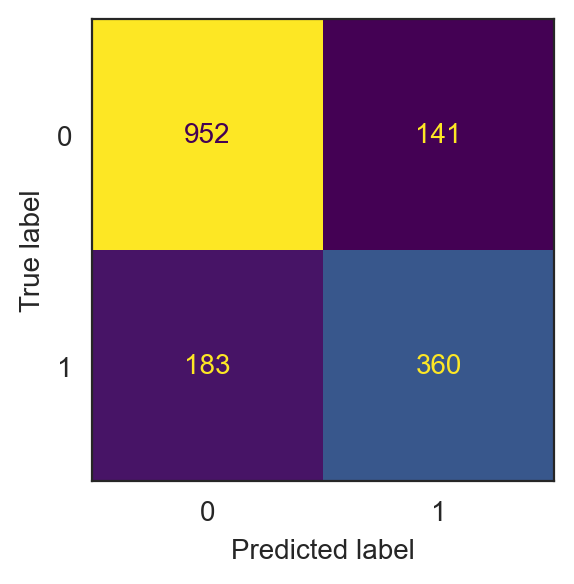

In [36]:
pipeline1 = Pipeline(steps=[
    ('transforming', column_transformer),
    ('regression', LogisticRegression(max_iter=10000, random_state=42))
])

lr_pipe = model_fit_predict(pipeline1, X_train, y_train, X_val, y_val)

#### GridSearch and CV 

In [37]:
def cv_results(model, model_name, X, y, cv=10):
    cv_scores = cross_val_score(model, X, y, 
                                scoring='f1', cv=cv)
    print('CV-scores:', ' | '.join(map(lambda x: str(round(x, 2)), cv_scores)))
    print(f'CV results for {model_name} on {cv} folds: %.5f' % cv_scores.mean())
    
cv_results(LogisticRegression(max_iter=10000, random_state=42), 
           'LogisticRegression', X_train_transf, y_train)

CV-scores: 0.67 | 0.67 | 0.71 | 0.72 | 0.71 | 0.71 | 0.68 | 0.73 | 0.68 | 0.64
CV results for LogisticRegression on 10 folds: 0.69244


In [38]:
def grid_search(model, X, y, params, scoring='f1', nfolds=5):    
    gscv = GridSearchCV(model, params, scoring=scoring, cv=nfolds, n_jobs=-1)
    gscv.fit(X, y)
    print('Best score: %.5f' % gscv.best_score_)
    print('Best params:', gscv.best_params_)
    return gscv

In [39]:
C_set = {'C': np.logspace(-1, 2, 15)}
lr_gs = grid_search(LogisticRegression(max_iter=10000, random_state=7), 
                    X_train_transf, y_train, C_set)

Best score: 0.69531
Best params: {'C': 0.7196856730011519}


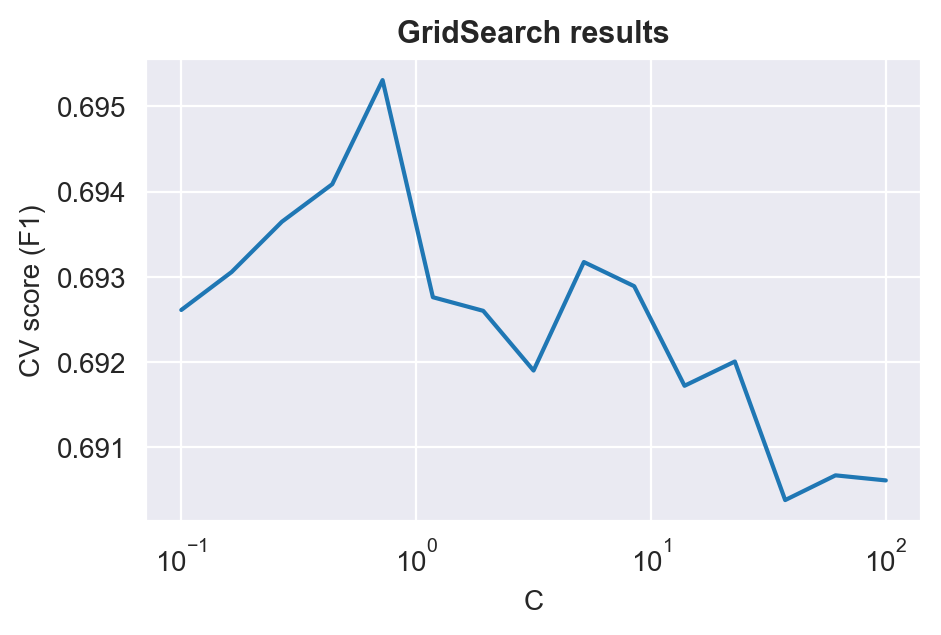

In [44]:
plt.figure(figsize=(5, 3))
plt.plot(C_set['C'], lr_gs.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('C', fontsize=10)
plt.ylabel('CV score (F1)', fontsize=10)
plt.title('GridSearch results', fontsize=11, weight='bold')
plt.show()

F1 score (train) = 0.71380
accuracy = 0.80990
F1 score = 0.70010
AUC-PR = 0.74402
AUC-ROC = 0.85863


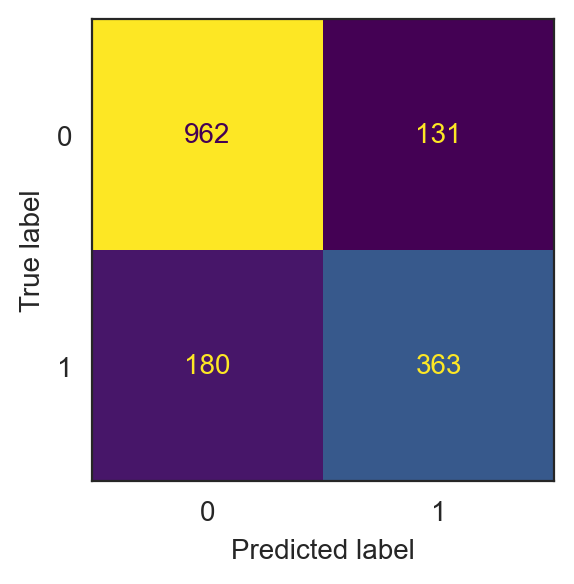

In [40]:
lr_cv = model_fit_predict(LogisticRegression(C=100, max_iter=10000, random_state=7),
                          X_train_transf, y_train, 
                          X_val_transf, y_val)

### Which features are important?

In [41]:
warnings.filterwarnings('ignore') 

# ohe_feat_names = column_transformer.transformers_[0][1].get_feature_names()
# bin_feat_names = column_transformer.transformers_[1][2]
scal_feat_names = column_transformer.transformers_[0][2]
pass_feat_names = X_train.columns[-25:]
# for i, el in enumerate(ohe_feat_names):
#     idx = el.split('_')[0][1:]
#     ohe_feat_names[i] = categoric[int(idx)] + ' ' + el.split('_')[1]

In [42]:
# ohe_feat_names_lst = list(map(lambda x: x + '(categor)', ohe_feat_names))
# bin_features_lst = list(map(lambda x: x + '(bin)', bin_feat_names)) 
numeric_features_lst = list(map(lambda x: x + '(numeric)', scal_feat_names)) 
pass_features_lst = list(map(lambda x: x + '(pass)', pass_feat_names)) 

# cols_coefs = list(zip(ohe_feat_names_lst + bin_features_lst + numeric_features_lst, lr_cv.coef_[0]))

cols_coefs = list(zip(numeric_features_lst + pass_features_lst, lr_cv.coef_[0]))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True) 

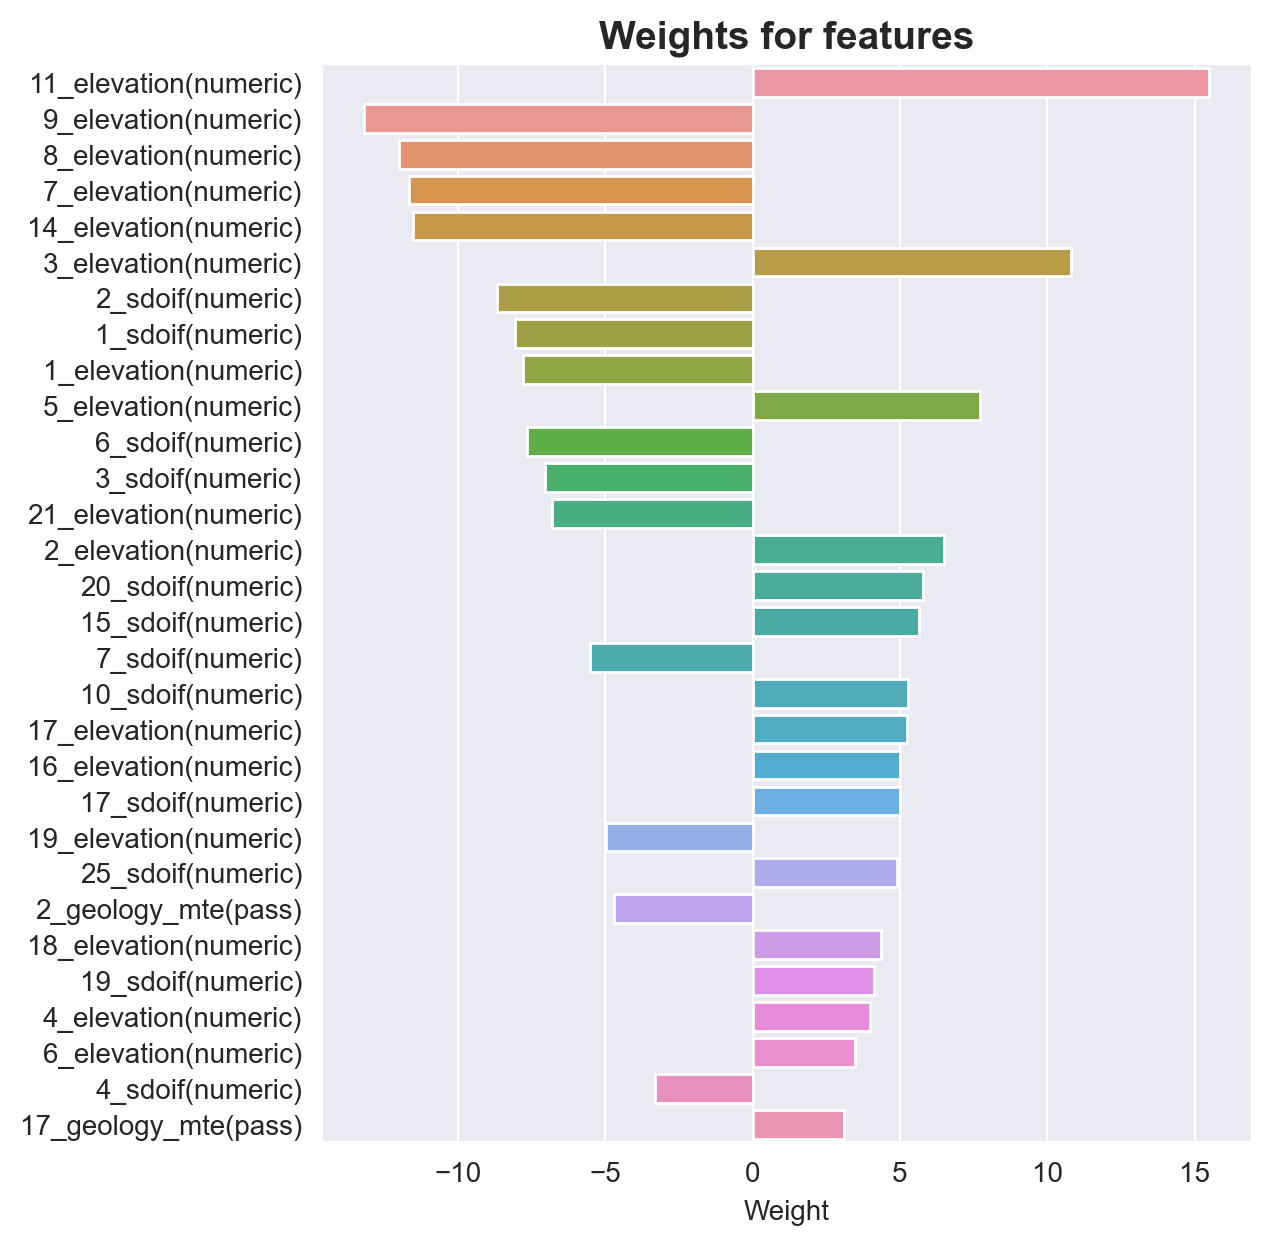

In [49]:
def show_weights(features_weights, top=True, linear=True, num=30):
    plt.figure(figsize=(6, 7))
    if top:
        weights = [x[1] for x in features_weights[:num]]
        features = [x[0] for x in features_weights[:num]]
    else:
        weights = [x[1] for x in features_weights[-num:]]
        features = [x[0] for x in features_weights[-num:]]
    sns.barplot(y=features, x=weights)
    if linear:
        plt.xlabel('Weight')
        plt.title('Weights for features', weight='bold', fontsize=14)
    else:
        plt.xlabel('Importance')
        plt.title('Importance of features', weight='bold', fontsize=14)
    plt.show()
    return features


feat = show_weights(cols_coefs_sorted)

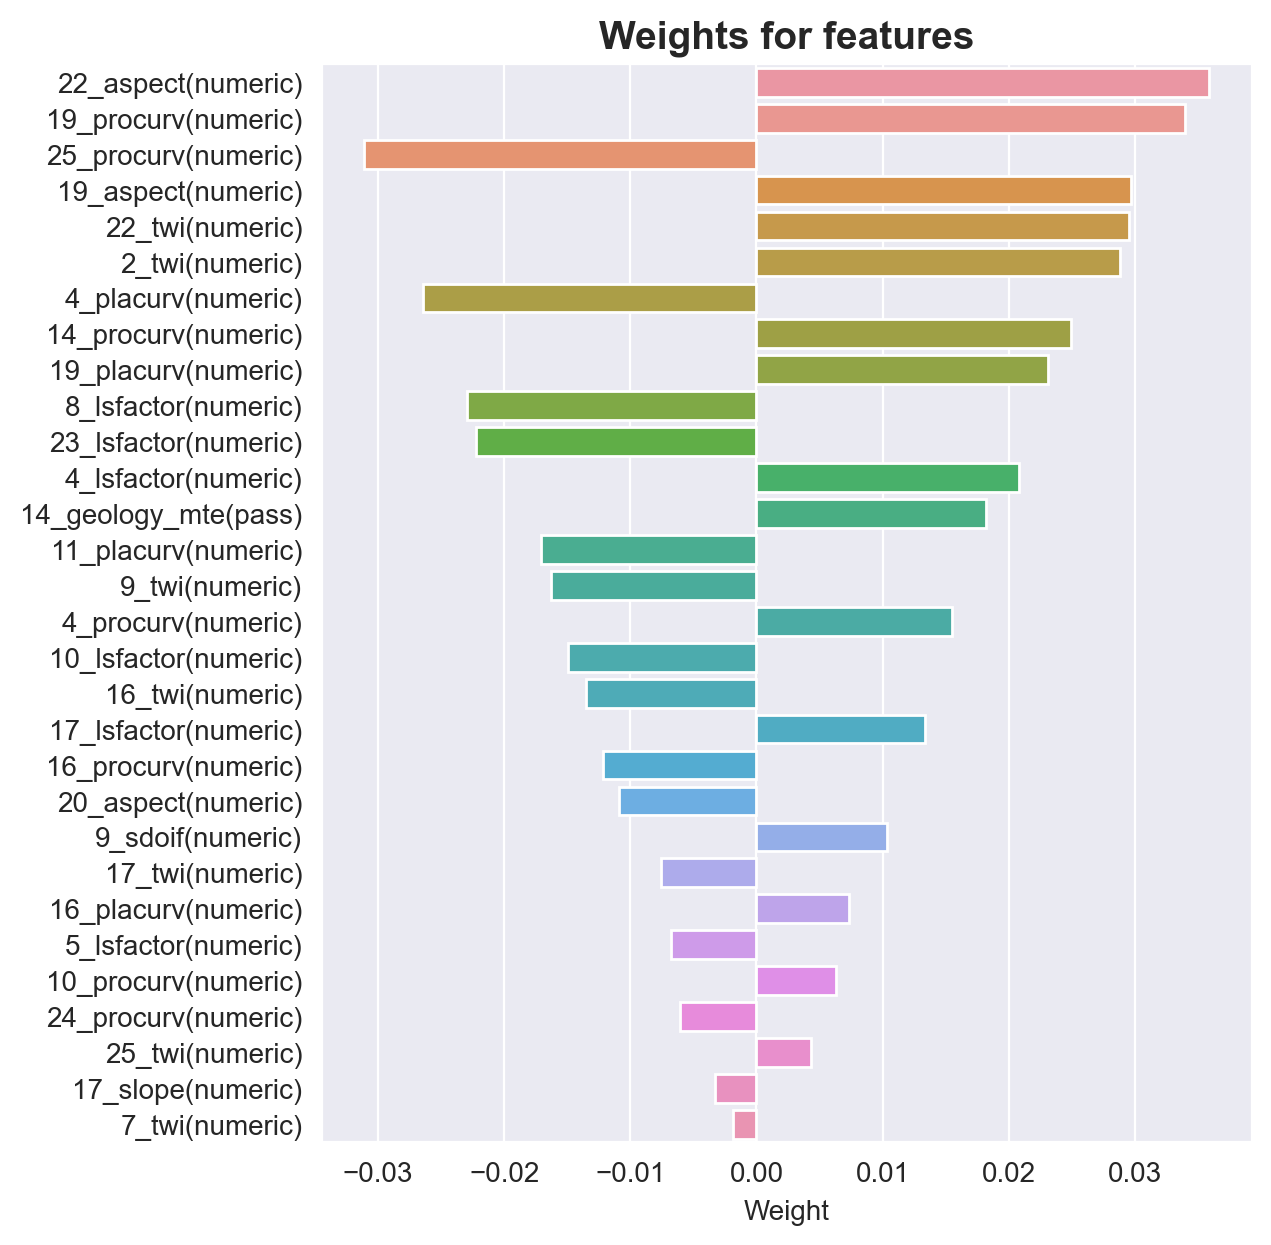

In [50]:
bad_feat = show_weights(cols_coefs_sorted, False)

In [39]:
bad_feat_logreg = [i[0] for i in cols_coefs_sorted[-50:]]
# bad_feat_logreg

### 4.2. SVM

F1 score (train) = 0.81792
accuracy = 0.82824
F1 score = 0.72955
AUC-PR = 0.79985
AUC-ROC = 0.87905


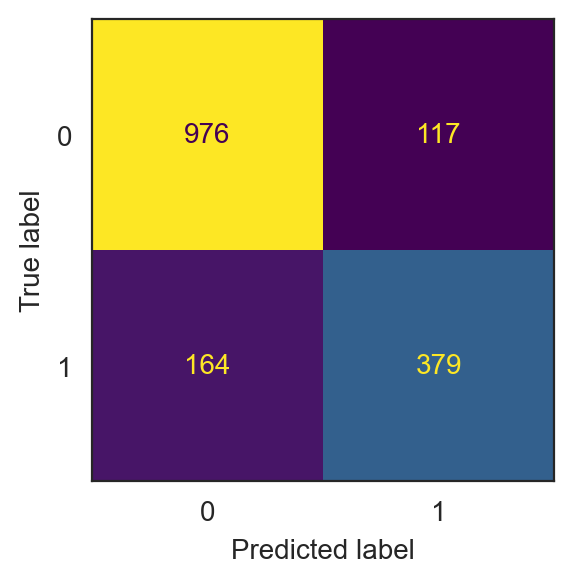

In [51]:
svm = model_fit_predict(SVC(probability=True, random_state=7), 
                         X_train_transf, y_train, 
                         X_val_transf, y_val)

In [64]:
C_set = {'C': np.logspace(-1, 2, 15)}
svc_gs = grid_search(SVC(random_state=7), 
                     X_train_transf, y_train, C_set)

Best score: 0.73746

Best params: {'C': 3.1622776601683795}


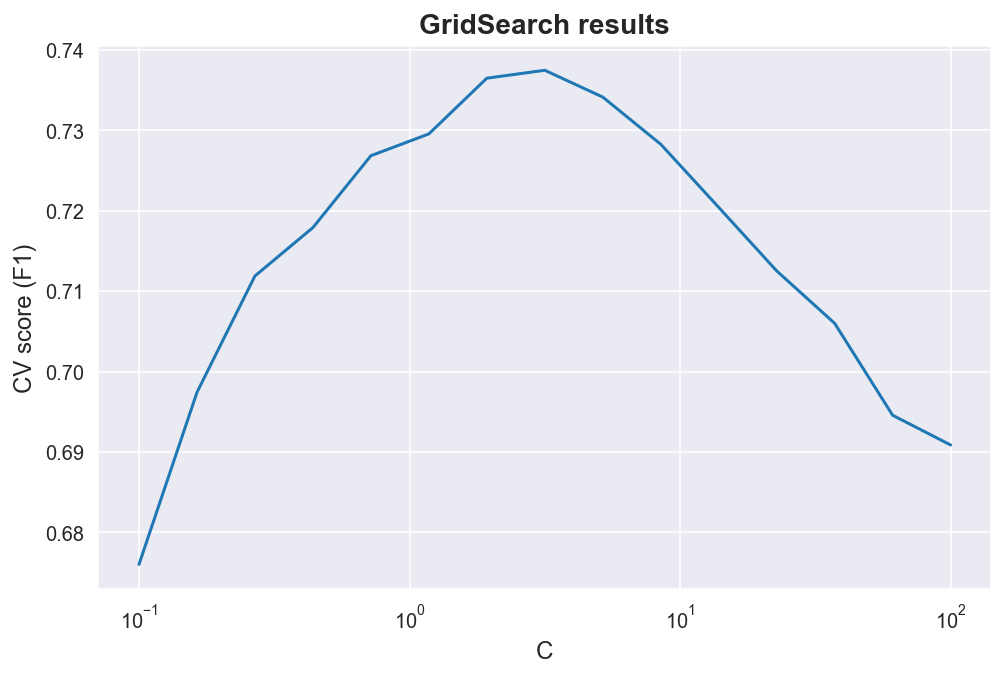

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(C_set['C'], svc_gs.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('C', fontsize=12)
plt.ylabel('CV score (F1)', fontsize=12)
plt.title('GridSearch results', fontsize=14, weight='bold')
plt.show()

F1 score (train) = 0.88587
accuracy = 0.83068
F1 score = 0.73893
AUC-PR = 0.79753
AUC-ROC = 0.87912


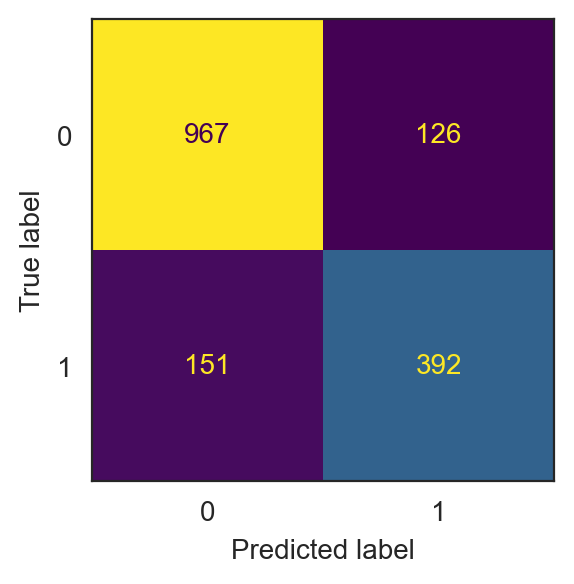

In [52]:
svm_cv = model_fit_predict(SVC(C=3.1622776601683795, 
                               probability=True, random_state=7), 
                           X_train_transf, y_train, 
                           X_val_transf, y_val)

### 4.3. Random Forest

In [41]:
n_estimators_lst = range(100, 800, 50)
scores = []
for n in n_estimators_lst:
    rf_est = RandomForestClassifier(n_estimators=n, criterion='entropy', random_state=42)
    rf_est.fit(X_train_transf, y_train)
    scores.append(metrics.f1_score(rf_est.predict(X_val_transf), y_val))

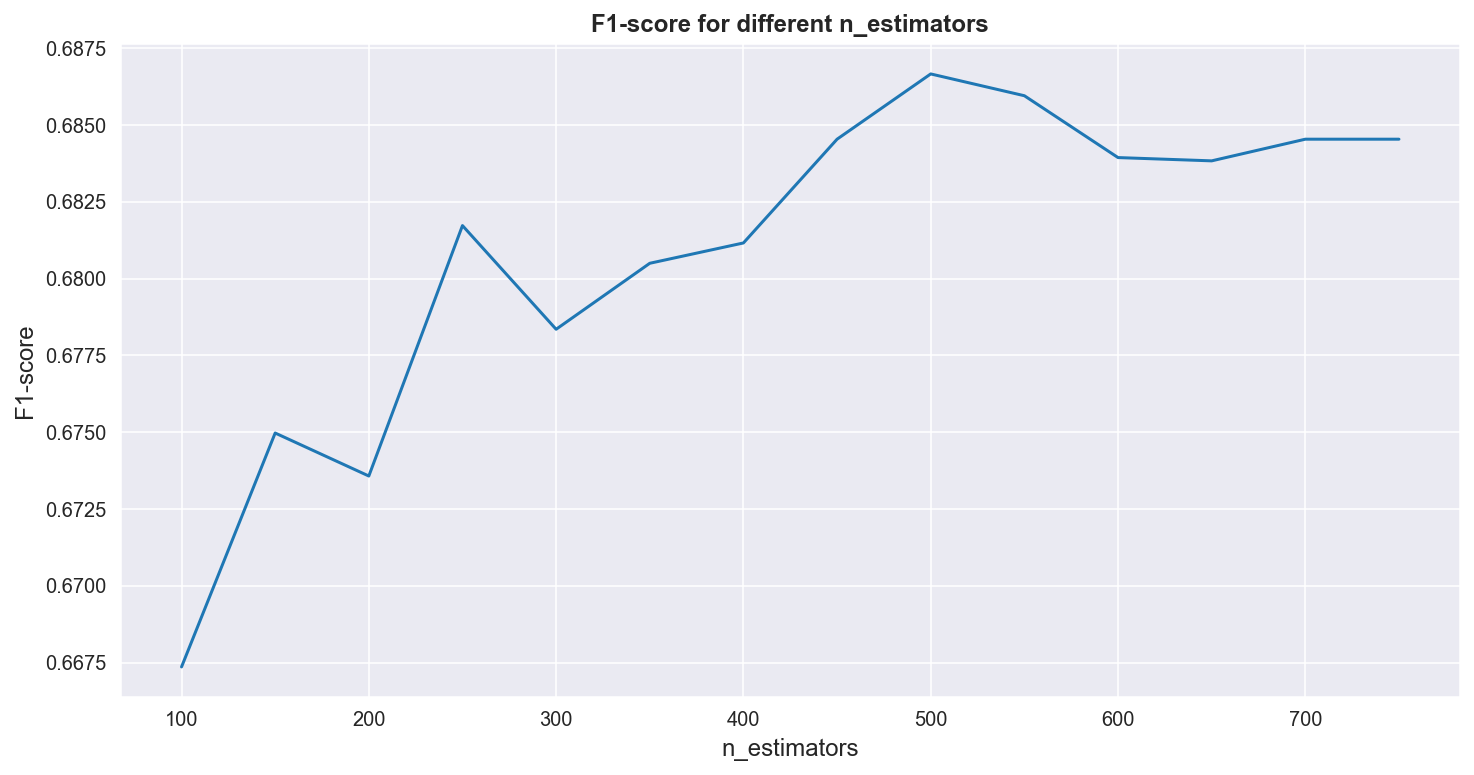

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_lst, scores)
plt.title('F1-score for different n_estimators', fontsize=12, weight='bold')
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.show()

F1 score (train) = 0.87993
accuracy = 0.81357
F1 score = 0.71254
AUC-PR = 0.78295
AUC-ROC = 0.87682


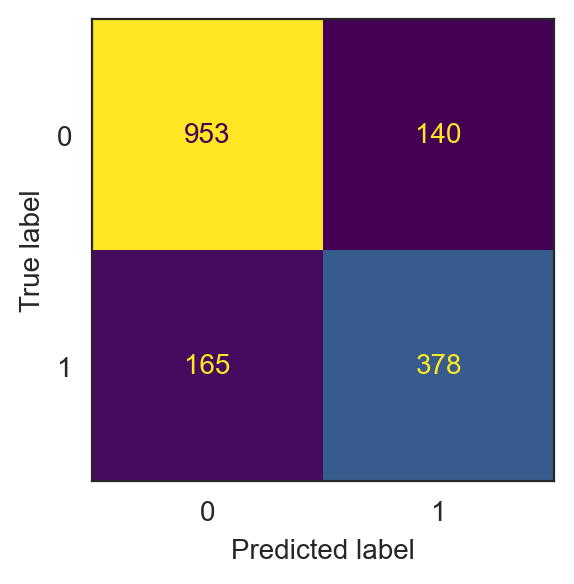

In [55]:
rfc = model_fit_predict(RandomForestClassifier(n_estimators=1000, max_depth=10,
                                                min_samples_leaf=6, criterion='entropy',
                                                random_state=42),
                        X_train_transf, y_train, 
                        X_val_transf, y_val)

Looks like in this case random forest is just not suitable, because it either gives a realy low quality or overfits (or both)

### Which features are important?

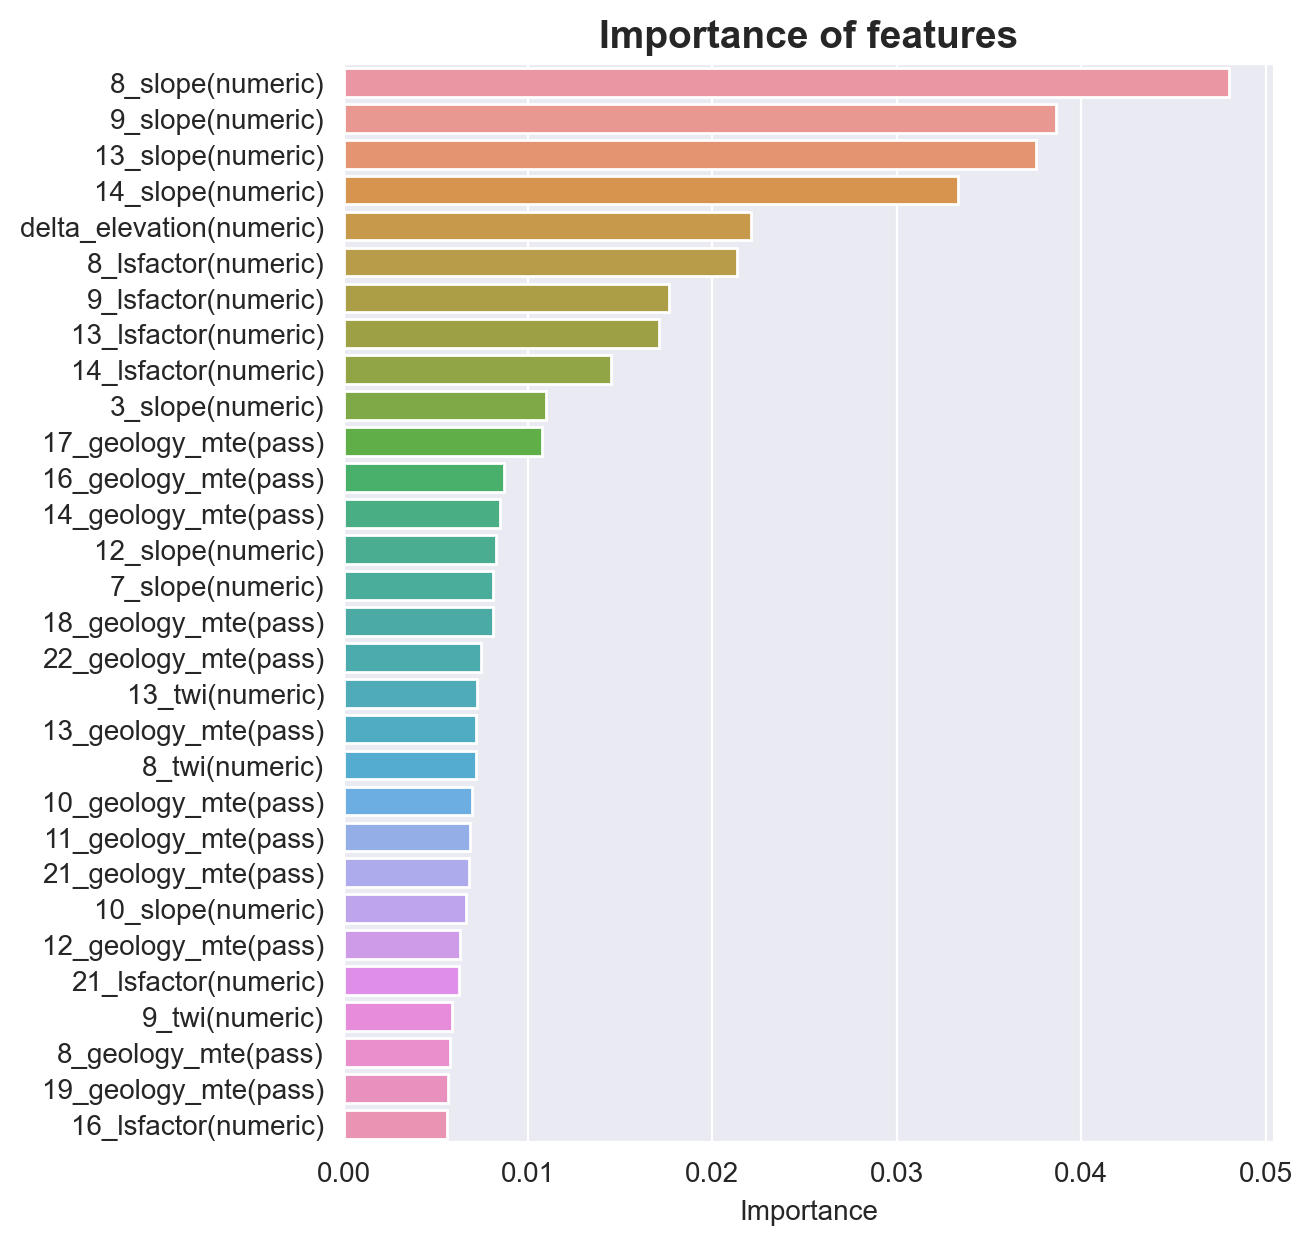

In [58]:
# cols_coefs = list(zip(ohe_feat_names_lst + bin_features_lst + numeric_features_lst, rfc.feature_importances_))
cols_coefs = list(zip(numeric_features_lst + pass_features_lst, rfc.feature_importances_))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True)

feat = show_weights(cols_coefs_sorted, num=30, linear=False)

In [59]:
bad_feat_rf = [i[0] for i in cols_coefs_sorted[-50:]]
# bad_feat_rf

In [149]:
param_grid_rfc = {
#     'n_estimators': [500, 1000],
     'max_depth': [None] + list(range(3, 18, 5)),
#     'criterion': ['gini', 'entropy'],
    'min_samples_leaf': range(1, 12, 4)
}

In [150]:
rf_gs = grid_search(RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=42), 
                    X_train_transf, y_train, param_grid_rfc)

Best score: 0.64384

Best params: {'max_depth': 13, 'min_samples_leaf': 1}


### 4.3. LGBM

F1 score (train) = 0.97922
accuracy = 0.83557
F1 score = 0.74454
AUC-PR = 0.81735
AUC-ROC = 0.89483


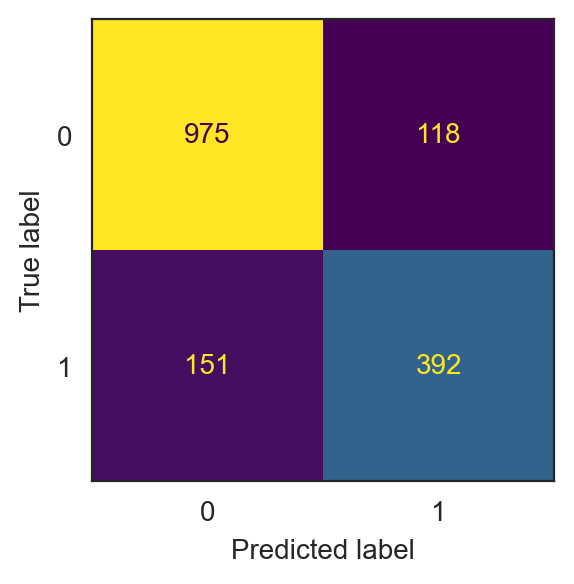

In [60]:
lgbm = model_fit_predict(LGBMClassifier(random_state=7), 
                         X_train_transf, y_train, 
                         X_val_transf, y_val)

In [51]:
lgbm = LGBMClassifier(random_state=42)
params_lgbm = {
    'n_estimators': list(range(100, 450, 50))
}

mod_lgbm = grid_search(lgbm, X_train_transf, y_train, params_lgbm)

Best score: 0.74390

Best params: {'n_estimators': 200}


In [52]:
lgbm = LGBMClassifier(n_estimators=200, random_state=42)
params_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.3]
}

mod_lgbm = grid_search(lgbm, X_train_transf, y_train, params_lgbm)

Best score: 0.74542

Best params: {'learning_rate': 0.25}


In [53]:
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.25, random_state=42)
params_lgbm = {
    'reg_alpha': np.logspace(-3, 0, 4),
    'reg_lambda': np.logspace(-3, 0, 4)
}

mod_lgbm = grid_search(lgbm, X_train_transf, y_train, params_lgbm)

Best score: 0.74675

Best params: {'reg_alpha': 0.001, 'reg_lambda': 0.001}


In [56]:
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.25,
                     reg_alpha=0.001, reg_lambda=0.001, random_state=42)
params_lgbm = {
    'max_depth': range(8, 28, 4)
}

mod_lgbm = grid_search(lgbm, X_train_transf, y_train, params_lgbm)

Best score: 0.74675

Best params: {'max_depth': 24}


F1 score (train) = 1.00000
accuracy = 0.84658
F1 score = 0.76027
AUC-PR = 0.83441
AUC-ROC = 0.90256


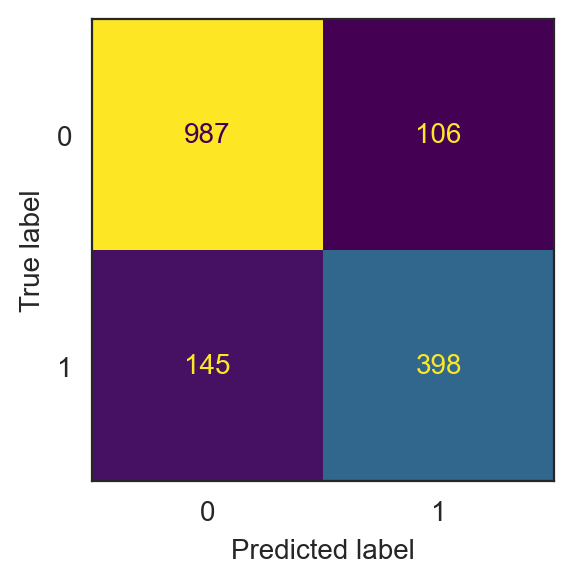

In [61]:
lgbm_best = LGBMClassifier(n_estimators=450, learning_rate=0.25, max_depth=20,
                          reg_alpha=0.001, reg_lambda=0.01, random_state=42)
lgbm_best = model_fit_predict(lgbm_best, X_train_transf, y_train, 
                              X_val_transf, y_val)

This is obviously an ovefitted LGBM, but we'll try to feed it into stacking algorithm and hope to get something good out of it.

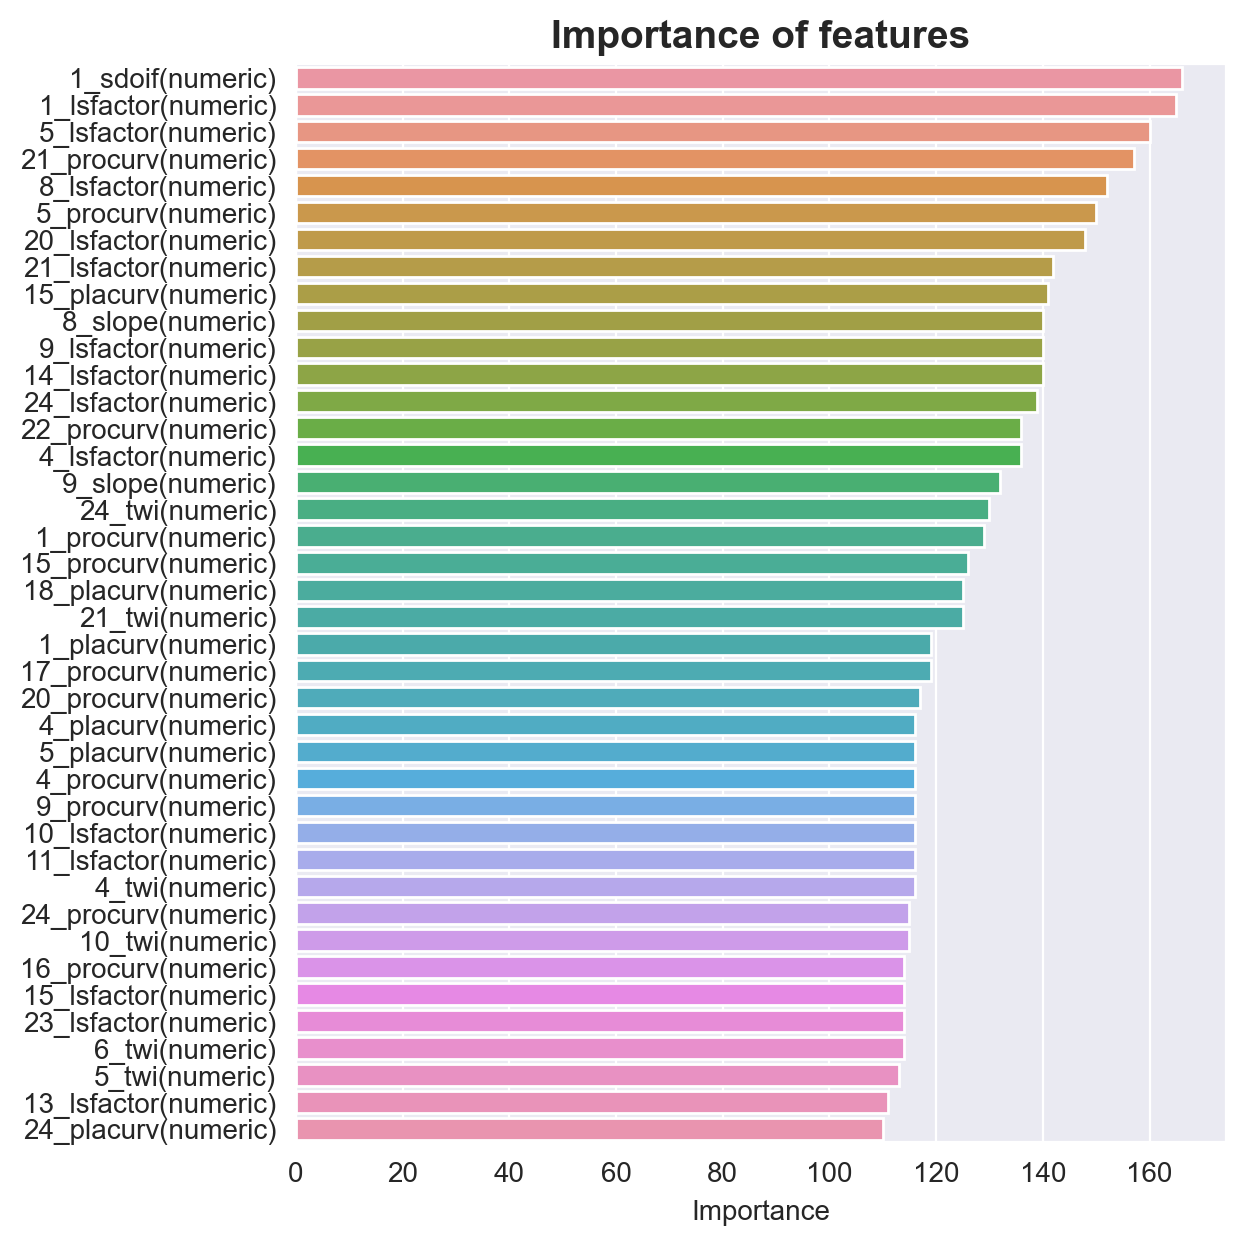

In [64]:
# cols_coefs = list(zip(ohe_feat_names_lst + bin_features_lst + numeric_features_lst, lgbm_best.feature_importances_))
cols_coefs = list(zip(numeric_features_lst + pass_features_lst, lgbm_best.feature_importances_))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True)

feat = show_weights(cols_coefs_sorted, num=40, linear=False)

In [63]:
bad_feat_lgbm = [i[0] for i in cols_coefs_sorted[-50:]]
# bad_feat_lgbm

In [40]:
# probs_df = pd.DataFrame(data={'probs': lgbm_best.predict_proba(X_val_transf)[:, 1],
#                    'labels':y_val}).sort_values(by='probs')#.plot(kind='scatter', x='probs', y='labels')
# outliers_idx = probs_df[(probs_df['probs'] > 0.8) & (probs_df['labels'] == 0)].index

### 4.4. Catboost

F1 score (train) = 0.87482
accuracy = 0.82274
F1 score = 0.72328
AUC-PR = 0.80139
AUC-ROC = 0.88840


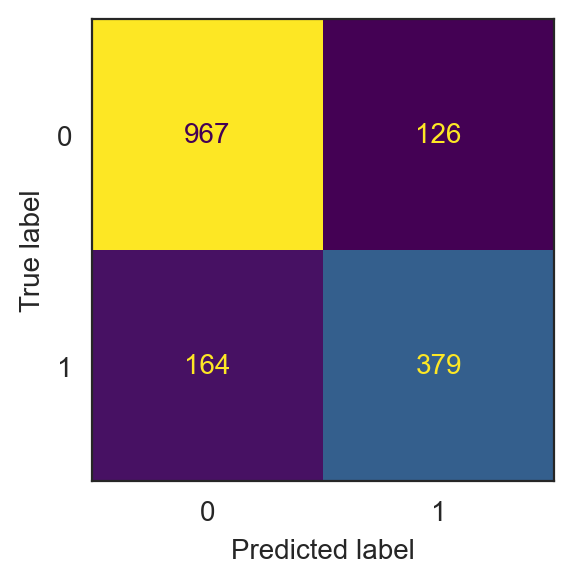

In [65]:
cbmodel = CatBoostClassifier(colsample_bylevel=0.2, depth=7,
                               learning_rate=0.01, n_estimators=1000, 
                               verbose=False, random_state=42)
cbmodel = model_fit_predict(cbmodel, X_train_transf, y_train, 
                              X_val_transf, y_val)

In [33]:
cb_gs = CatBoostClassifier(n_estimators=200, verbose=False, random_state=42)

grid = {'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'depth': range(3, 12, 3),
#         'l2_leaf_reg': [0.1, 1, 5, 9],
#        'n_estimators': range(500, 2500, 500)
       }

# grid_search_result = cb_gs.grid_search(grid, 
#                                        X=X_train_transf, 
#                                        y=y_train, 
#                                        plot=True)
mod_cb = grid_search(cb_gs, X_train_transf, y_train, grid)

Best score: 0.67960

Best params: {'depth': 9, 'learning_rate': 0.1}


F1 score (train) = 1.00000
accuracy = 0.83007
F1 score = 0.73269
AUC-PR = 0.81985
AUC-ROC = 0.89643


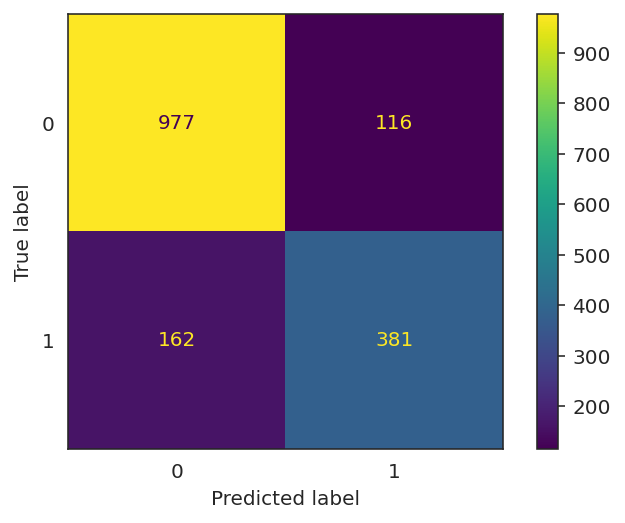

In [60]:
cbmodel_best = CatBoostClassifier(colsample_bylevel=0.2, depth=9,
                                  learning_rate=0.1, n_estimators=1000, 
                                  verbose=False, random_state=42)
cbmodel_best = model_fit_predict(cbmodel_best, X_train_transf, y_train, 
                                 X_val_transf, y_val)

F1 score (train) = 0.98118
accuracy = 0.83068
F1 score = 0.73694
AUC-PR = 0.81240
AUC-ROC = 0.89412


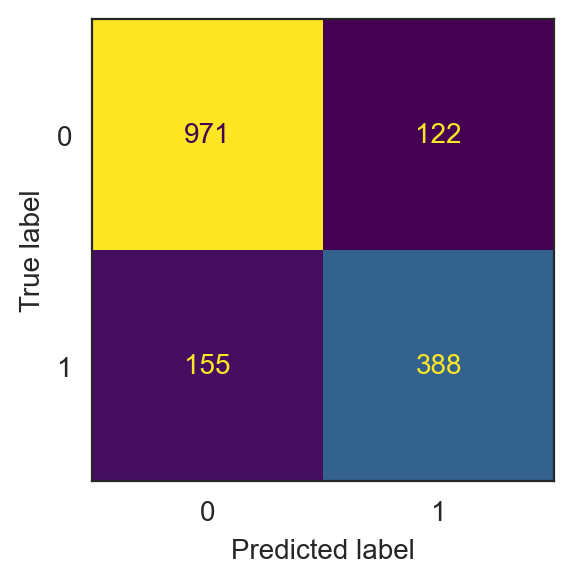

In [66]:
cbmodel_best = CatBoostClassifier(depth=7, verbose=False, random_state=42)
cbmodel_best = model_fit_predict(cbmodel_best, X_train_transf, y_train, 
                              X_val_transf, y_val)

Once again we obviously have an overfitted catboost, but still I'm going to feed it straight into stacking.

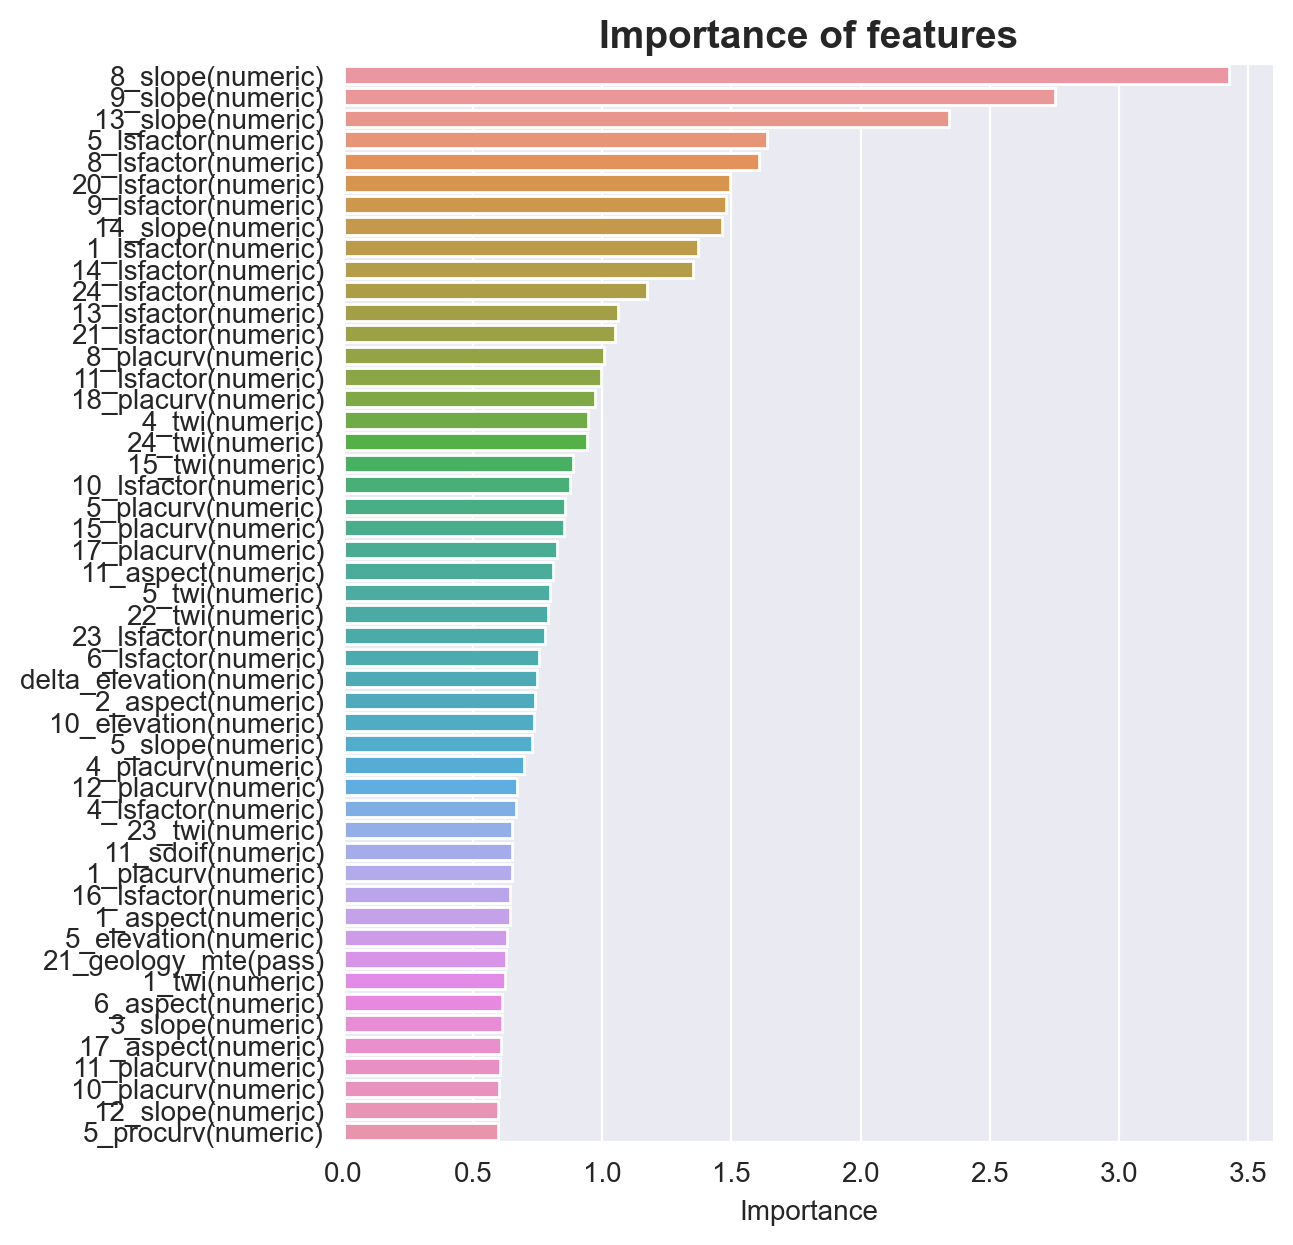

In [67]:
# cols_coefs = list(zip(ohe_feat_names_lst + bin_features_lst + numeric_features_lst, cbmodel_best.feature_importances_))
cols_coefs = list(zip(numeric_features_lst + pass_features_lst, cbmodel_best.feature_importances_))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True)

feat = show_weights(cols_coefs_sorted, num=50, linear=False)

In [68]:
bad_feat_cb = [i[0] for i in cols_coefs_sorted[-50:]]
# bad_feat_cb

In [69]:
# set(bad_feat_rf) & set(bad_feat_lgbm) & set(bad_feat_cb) & set(bad_feat_logreg)

### 4.5. Stacking

F1 score (train) = 1.00000
accuracy = 0.84474
F1 score = 0.75763
AUC-PR = 0.82362
AUC-ROC = 0.89883


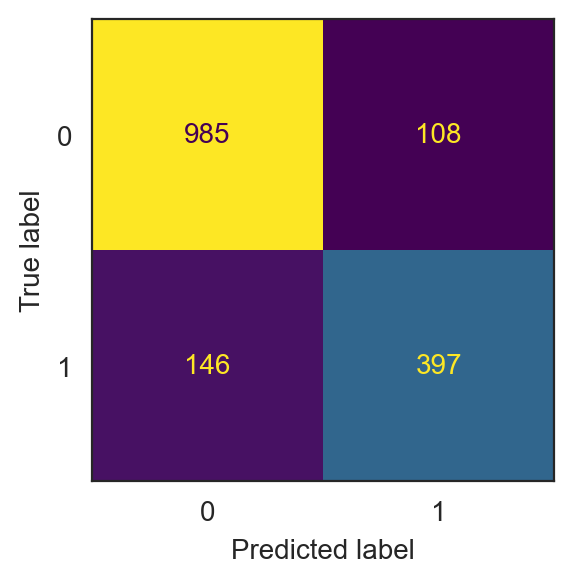

In [70]:
stacked = StackingClassifier([svm_cv, lgbm_best, cbmodel_best], 
                             meta_classifier=LogisticRegression(), use_probas=True)

stacked_model = model_fit_predict(stacked, X_train_transf, y_train, 
                                 X_val_transf, y_val)

**Finally, we might want to tune a threshold for our model**

In [71]:
y_predicted_proba = pd.Series(stacked_model.predict_proba(X_val_transf)[:,1])

def tune_treshold(proba,threshold):
    if proba > threshold:
        return 1
    else:
        return 0
    
threshold_range = np.arange(0, 1, 0.001)
f1_scores_lst = []
for i in threshold_range:
    tuned_predictions = y_predicted_proba.apply(tune_treshold, args=(i,))
    f1_scores_lst.append(f1_score(tuned_predictions, y_val))

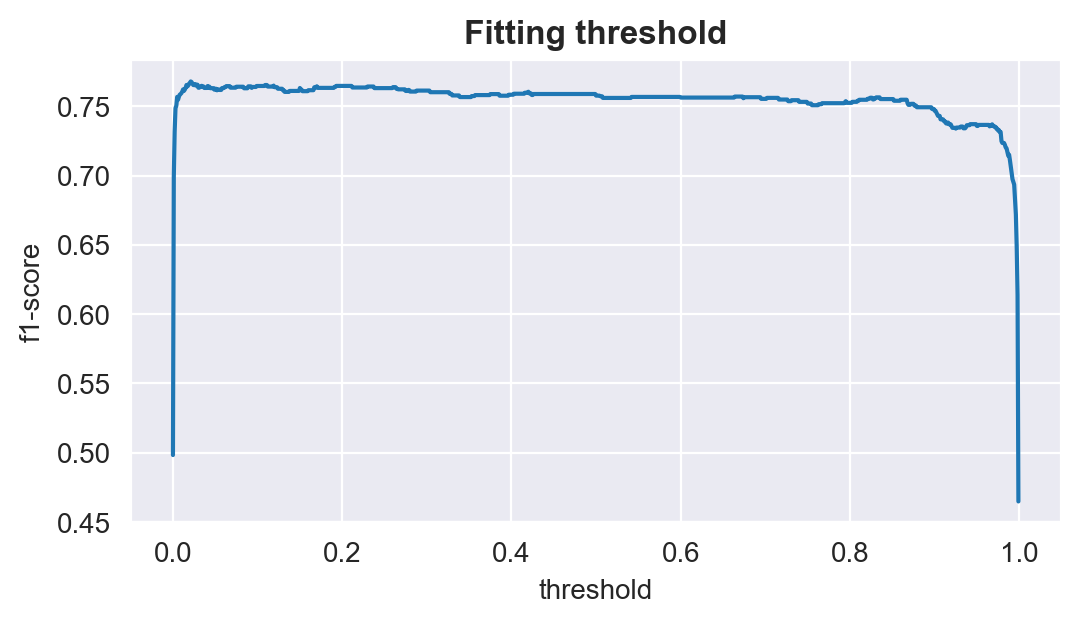

In [75]:
fig = plt.figure(figsize=(6, 3))
plt.plot(threshold_range, f1_scores_lst)
plt.xlabel('threshold', fontsize=10)
plt.ylabel('f1-score', fontsize=10)
plt.title('Fitting threshold', fontsize=12, weight='bold')
plt.show()

In [76]:
# top-10 thresholds by score on validation-set
# final submit is done for 0.021
sorted(list(zip(threshold_range, f1_scores_lst)), 
       key=lambda x: x[1], reverse=True)[:10]

[(0.021, 0.7678729037952339),
 (0.022, 0.7674624226348364),
 (0.02, 0.7665198237885462),
 (0.023, 0.7663716814159293),
 (0.019, 0.766256590509666),
 (0.026000000000000002, 0.7659574468085106),
 (0.028, 0.7655417406749556),
 (0.029, 0.7655417406749556),
 (0.016, 0.7653239929947461),
 (0.109, 0.765296803652968)]

### Final submit

In [77]:
y_predicted_proba = pd.Series(stacked_model.predict_proba(X_test_transf)[:,1])
predictions = y_predicted_proba.apply(tune_treshold, args=(0.021,))
output = pd.DataFrame({'Sample_ID': test.Sample_ID, 'Label': predictions})
output.to_csv('landslide_threshold.csv', index=False)

In [79]:
# predictions = stacked_model.predict(X_test_transf)
# output = pd.DataFrame({'Sample_ID': test.Sample_ID, 'Label': predictions})
# output.to_csv('landslide_stacking_mte.csv', index=False)

In [78]:
# !pip freeze > requirements.txt